In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Set a nice style for plots
plt.style.use('seaborn-v0_8-whitegrid')

In [46]:
df = pd.read_excel("NAVCO 1.2 Updated.xlsx")

df['DURATION'] = pd.to_numeric(df['DURATION'], errors='coerce')

binary_flags = [
    'SUCCESS', 'LIMITED', 'FAILURE', 'ONGOING', 'NONVIOL', 'VIOL',
    'DEFECT', 'VIOLENT FLANK', 'VIOLSIM', 'STATESUP', 'REGAID'
]
for flag in binary_flags:
    if flag in df.columns:
        df[flag] = pd.to_numeric(df[flag], errors='coerce').fillna(0).astype(int)
    else: # If a flag column is missing in the sample, add it with 0s
        df[flag] = 0


df.head()

,NAVCO ID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,...,OTHER,DURATION,PARTICIPATION,PERCENTAGE POPULAR PARTICIPATION,REGVIOL,DEFECT,VIOLENT FLANK,VIOLSIM,REGAID,STATESUP
0,4,Afghans,Afghanistan,1978,1979,Afghan government,1,0,0,0,...,0,613,10000.0,0.000641,1,1,0,1,1,1
1,3,Afghan resistance,Afghanistan,1980,1989,Soviet occupation,1,0,0,0,...,0,3281,10000.0,0.000685,1,0,0,1,0,1
2,218,Taliban/anti-government forces,Afghanistan,1992,1996,Afghan regime,1,0,0,0,...,0,1370,20000.0,0.000893,1,0,0,1,0,0
3,217,Taliban,Afghanistan,2001,2014,Afghan government,0,0,1,1,...,0,4391,60000.0,0.001625,1,1,0,1,1,0
4,5,Albanian anti-communist,Albania,1990,1991,Communist regime,1,0,0,0,...,0,442,300000.0,0.091068,1,0,0,1,1,0


In [47]:
params = {
    'B_succ': 100,  # Benefit for full success
    'B_lim': 50,    # Benefit for limited success
    'B_fail': 0,  # Benefit (cost) for failure
    'C_viol_choice': -30, # Inherent cost of choosing a violent strategy
    'c_d': -0.05,   # Cost per day of duration (scaled to be reasonable)
    'M_defect': 20, # Modifier for security force defections
    'M_vflank': -10, # Modifier for violent flank in non-violent campaign
    'M_violsim': -15, # Modifier for simultaneous different violent campaign
    'M_statesup': 25, # Modifier for external state support for campaign
    'M_regaid': -25,  # Modifier for external state aid for target regime
}

print("\nPayoff Parameters:")
print(params)


Payoff Parameters:
{'B_succ': 100, 'B_lim': 50, 'B_fail': 0, 'C_viol_choice': -30, 'c_d': -0.05, 'M_defect': 20, 'M_vflank': -10, 'M_violsim': -15, 'M_statesup': 25, 'M_regaid': -25}


In [48]:
def calculate_protester_payoff(row, parameters):
    """
    Calculates the protester's payoff and determines strategy and regime response
    for a single campaign.
    Returns:
        tuple: (protester_strategy, regime_response, payoff)
               Returns (None, None, None) or (strategy, None, None) if critical info is missing.
    """
    payoff = 0
    protester_strategy = None
    regime_response = None # Initialize regime_response

    # 1. Determine Protester Strategy (s)
    if row.get('VIOL', 0) == 1:
        protester_strategy = 'v'  # Violent
    elif row.get('NONVIOL', 0) == 1:
        protester_strategy = 'p'  # Peaceful
    else:
        # Should not happen with NAVCO data if VIOL/NONVIOL are primary classifications
        return None, None, None # Strategy, Regime Response, Payoff

    # 2. Determine Regime Response (sigma)
    # NAVCO 1.2: ONGOING implies FAILURE for outcome coding
    if row.get('SUCCESS', 0) == 1:
        regime_response = 'm_succ'  # Internal code for Meet - Full Success
    elif row.get('LIMITED', 0) == 1:
        regime_response = 'm_lim'   # Internal code for Meet - Limited Success
    elif row.get('FAILURE', 0) == 1 or row.get('ONGOING', 0) == 1:
        regime_response = 'r'       # Internal code for Reject / Failure / Ongoing
    else:
        # This case should ideally not occur if outcomes are well-defined
        # Return strategy, but None for regime_response and payoff
        return protester_strategy, None, None

    # 3. Calculate Benefit Component B(s, sigma)
    if regime_response == 'm_succ':
        payoff += parameters['B_succ']
    elif regime_response == 'm_lim':
        payoff += parameters['B_lim']
    elif regime_response == 'r':
        payoff += parameters['B_fail']
    # If regime_response is None here (e.g. from the else block above),
    # payoff related to B might not be added, which is consistent.

    # 4. Calculate Cost Component C(s, sigma)
    # Inherent Strategy Cost
    if protester_strategy == 'v':
        payoff += parameters['C_viol_choice']

    # Operational Costs (Duration)
    # Ensure DURATION is numeric and not NaN before using it
    duration_val = row.get('DURATION')
    if pd.notna(duration_val): # pd.to_numeric was already applied
        payoff += parameters['c_d'] * duration_val

    # Contextual Modifiers
    if row.get('DEFECT', 0) == 1:
        payoff += parameters['M_defect']
    if protester_strategy == 'p' and row.get('VIOLENT FLANK', 0) == 1:
        payoff += parameters['M_vflank']
    # if row.get('VIOLSIM', 0) == 1:
    #     payoff += parameters['M_violsim']
    if row.get('STATESUP', 0) == 1:  # Campaign received aid
        payoff += parameters['M_statesup']
    if row.get('REGAID', 0) == 1:  # Regime received aid
        payoff += parameters['M_regaid']

    return protester_strategy, regime_response, payoff

In [49]:
# Apply the function to each row
# The result of apply will be a Series of tuples (strategy, internal_regime_resp, payoff)
results_series = df.apply(
    lambda row: calculate_protester_payoff(row, params), axis=1
)

# Expand the Series of tuples into three new columns
# Add checks for the type and length of results from the lambda
df['protester_strategy'] = results_series.apply(
    lambda x: x[0] if isinstance(x, tuple) and len(x) == 3 else None
)
df['internal_regime_response'] = results_series.apply(
    lambda x: x[1] if isinstance(x, tuple) and len(x) == 3 else None
)
df['protester_payoff'] = results_series.apply(
    lambda x: x[2] if isinstance(x, tuple) and len(x) == 3 else None
)

# Define the mapping from internal codes to final 'f', 'l', 'r'
regime_response_final_mapping = {
    'm_succ': 'f',  # Meet - Full Success maps to 'f'
    'm_lim': 'l',   # Meet - Limited Success maps to 'l'
    'r': 'r'        # Reject / Failure / Ongoing maps to 'r'
}
df['regime_response_mapped'] = df['internal_regime_response'].map(
    regime_response_final_mapping
)

# Drop rows where essential information could not be determined
# This now includes 'regime_response_mapped'
df_analyzed = df.dropna(
    subset=['protester_strategy', 'protester_payoff', 'regime_response_mapped']
).copy() # Use .copy() to avoid SettingWithCopyWarning on df_analyzed later

print("\nDataFrame with Calculated Payoffs and Mapped Regime Response:")
# Select columns to display for verification
display_cols = [
    'NAVCO ID', 'BYEAR', 'SUCCESS', 'LIMITED', 'FAILURE', 'ONGOING', # Original outcomes
    'protester_strategy', 'internal_regime_response',
    'regime_response_mapped', 'protester_payoff' # Derived values
]
# Filter out columns that might not exist in all versions of df for display
display_cols = [col for col in display_cols if col in df_analyzed.columns]
display(df_analyzed[display_cols].head())

print("\nValue counts for regime_response_mapped:")
display(df_analyzed['regime_response_mapped'].value_counts(dropna=False))
print(f"\nShape of df_analyzed: {df_analyzed.shape}")



DataFrame with Calculated Payoffs and Mapped Regime Response:


,NAVCO ID,BYEAR,SUCCESS,LIMITED,FAILURE,ONGOING,protester_strategy,internal_regime_response,regime_response_mapped,protester_payoff
0,4,1978,1,0,0,0,v,m_succ,f,59.35
1,3,1980,1,0,0,0,v,m_succ,f,-69.05
2,218,1992,1,0,0,0,v,m_succ,f,1.50
3,217,2001,0,0,1,1,v,r,r,-254.55
4,5,1990,1,0,0,0,p,m_succ,f,52.90



Value counts for regime_response_mapped:


regime_response_mapped
r    195
f    150
l     44
Name: count, dtype: int64


Shape of df_analyzed: (389, 29)


In [50]:
# Define time periods (e.g., decades)
# NAVCO 1.2: 1945-2013
min_year = df_analyzed['BYEAR'].min()
max_year = df_analyzed['BYEAR'].max()

# Create decade bins.
# Ensure bins cover the full range.
bins = list(range(int(min_year // 10 * 10), int(max_year // 10 * 10) + 20, 10))
labels = [
    f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)
] 
# Filter labels to match actual data range if necessary, or ensure bins are appropriate
# For this example, let's make labels based on actual data range for robustness
actual_labels = []
for i in range(len(bins)-1):
    if bins[i] <= max_year and bins[i+1]-1 >= min_year:
        actual_labels.append(f"{bins[i]}-{bins[i+1]-1}")

if not actual_labels: # Fallback if binning logic is off for small sample
    if len(bins) > 1:
      actual_labels = [f"{bins[0]}-{bins[-1]-1}"]
    else:
      actual_labels = ["Default Period"]


# Ensure 'BYEAR' is int for pd.cut
df_analyzed['BYEAR'] = df_analyzed['BYEAR'].astype(int)

# Handle cases where bins might not perfectly align with few data points
# by adjusting the bins or labels dynamically if needed.
if max_year - min_year < 20 and len(df_analyzed['BYEAR'].unique()) > 1 : # Small range, few unique years
    unique_sorted_years = sorted(df_analyzed['BYEAR'].unique())
    bins = [unique_sorted_years[0] -1] + [y + 0.5 for y in unique_sorted_years[:-1]] + [unique_sorted_years[-1] + 1]
    labels = [str(y) for y in unique_sorted_years]
    df_analyzed['time_period'] = pd.cut(
        df_analyzed['BYEAR'], bins=bins, labels=labels, right=False, include_lowest=True
    )
elif len(df_analyzed['BYEAR'].unique()) == 1:
    df_analyzed['time_period'] = str(df_analyzed['BYEAR'].iloc[0])
else: # Default decade binning
    df_analyzed['time_period'] = pd.cut(
        df_analyzed['BYEAR'], bins=bins, labels=actual_labels, right=False, include_lowest=True
    )


# Group by time period and calculate EGT metrics
temporal_summary_list = []

for period, group in df_analyzed.groupby('time_period', observed=True):
    num_total_campaigns = len(group)
    if num_total_campaigns == 0:
        continue

    peaceful_campaigns = group[group['protester_strategy'] == 'p']
    violent_campaigns = group[group['protester_strategy'] == 'v']

    num_peaceful = len(peaceful_campaigns)
    num_violent = len(violent_campaigns)

    x_N_t = num_peaceful / num_total_campaigns if num_total_campaigns > 0 else 0
    x_V_t = num_violent / num_total_campaigns if num_total_campaigns > 0 else 0
    
    E_N_t = peaceful_campaigns['protester_payoff'].mean() if num_peaceful > 0 else 0
    E_V_t = violent_campaigns['protester_payoff'].mean() if num_violent > 0 else 0
    
    # Handle cases where a strategy might not be present (mean of empty is NaN)
    if pd.isna(E_N_t): E_N_t = 0
    if pd.isna(E_V_t): E_V_t = 0

    E_avg_t = (x_N_t * E_N_t) + (x_V_t * E_V_t)
    
    # Replicator dynamics component for non-violent strategy
    # dxN_dt_factor = x_P_t * (E_P_t - E_avg_t) # This is the RHS of the equation
    # For plotting, we are interested in (E_P_t - E_avg_t)
    fitness_diff_N = E_N_t - E_avg_t
    
    # Replicator dynamics component for violent strategy
    fitness_diff_V = E_V_t - E_avg_t

    temporal_summary_list.append({
        'time_period': period,
        'x_P_t': x_N_t, # Proportion of non-violent
        'x_V_t': x_V_t, # Proportion of violent
        'E_P_t': E_N_t, # Avg payoff non-violent
        'E_V_t': E_V_t, # Avg payoff violent
        'E_avg_t': E_avg_t, # Avg payoff all
        'fitness_diff_P': fitness_diff_N, # (E_N - E_avg)
        'fitness_diff_V': fitness_diff_V, # (E_V - E_avg)
        'num_peaceful': num_peaceful,
        'num_violent': num_violent,
        'num_total': num_total_campaigns
    })

temporal_df = pd.DataFrame(temporal_summary_list)

print("\nTemporal Summary:")
temporal_df



Temporal Summary:


,time_period,x_P_t,x_V_t,E_P_t,E_V_t,E_avg_t,fitness_diff_P,fitness_diff_V,num_peaceful,num_violent,num_total
0,1940-1949,0.137931,0.862069,3.800000,-132.976000,-114.110345,117.910345,-18.865655,4,25,29
1,1950-1959,0.275862,0.724138,-10.087500,-90.021429,-67.970690,57.883190,-22.050739,8,21,29
2,1960-1969,0.170732,0.829268,19.128571,-212.807353,-173.208537,192.337108,-39.598816,7,34,41
3,1970-1979,0.358491,0.641509,-16.157895,-221.332353,-147.779245,131.621351,-73.553108,19,34,53
4,1980-1989,0.554054,0.445946,11.062195,-231.869697,-97.272297,108.334492,-134.597400,41,33,74
5,1990-1999,0.358209,0.641791,47.243750,-82.063953,-35.744776,82.988526,-46.319177,24,43,67
6,2000-2009,0.677966,0.322034,44.562500,-123.265789,-9.483898,54.046398,-113.781891,40,19,59
7,2010-2019,0.702703,0.297297,18.163462,-27.790909,4.501351,13.662110,-32.292260,26,11,37


In [51]:
# Ensure temporal_df exists and is not empty before proceeding
if not temporal_df.empty:
    # Select and rename columns for presentation
    # 'fitness_diff_V' is now already in temporal_df
    replicator_components_df = temporal_df[
        [
            "time_period",
            "x_P_t",
            "x_V_t",
            "E_P_t",
            "E_V_t",
            "E_avg_t",
            "fitness_diff_P",
            "fitness_diff_V",
        ]
    ].copy() # Use .copy() to avoid SettingWithCopyWarning on the slice

    replicator_components_df.columns = [
        "Time Period",
        "x_P,t",
        "x_V,t",
        "E_P,t",
        "E_V,t",
        "E_avg,t",
        "Fitness Diff P (E_P - E_avg)",
        "Fitness Diff V (E_V - E_avg)",
    ]
    print("\nReplicator Dynamics Components per Time Period:")
    display(replicator_components_df)
else:
    print("\nTemporal DataFrame is empty. Cannot create Replicator Components table.")


Replicator Dynamics Components per Time Period:


,Time Period,"x_P,t","x_V,t","E_P,t","E_V,t","E_avg,t",Fitness Diff P (E_P - E_avg),Fitness Diff V (E_V - E_avg)
0,1940-1949,0.137931,0.862069,3.800000,-132.976000,-114.110345,117.910345,-18.865655
1,1950-1959,0.275862,0.724138,-10.087500,-90.021429,-67.970690,57.883190,-22.050739
2,1960-1969,0.170732,0.829268,19.128571,-212.807353,-173.208537,192.337108,-39.598816
3,1970-1979,0.358491,0.641509,-16.157895,-221.332353,-147.779245,131.621351,-73.553108
4,1980-1989,0.554054,0.445946,11.062195,-231.869697,-97.272297,108.334492,-134.597400
5,1990-1999,0.358209,0.641791,47.243750,-82.063953,-35.744776,82.988526,-46.319177
6,2000-2009,0.677966,0.322034,44.562500,-123.265789,-9.483898,54.046398,-113.781891
7,2010-2019,0.702703,0.297297,18.163462,-27.790909,4.501351,13.662110,-32.292260


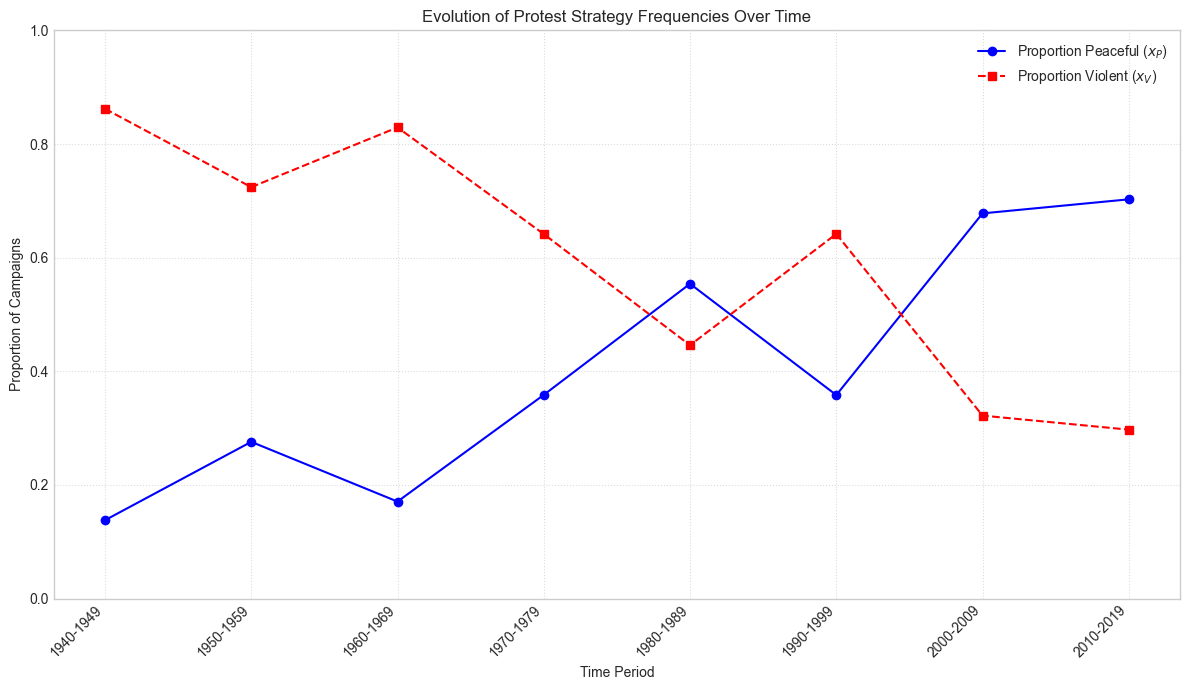

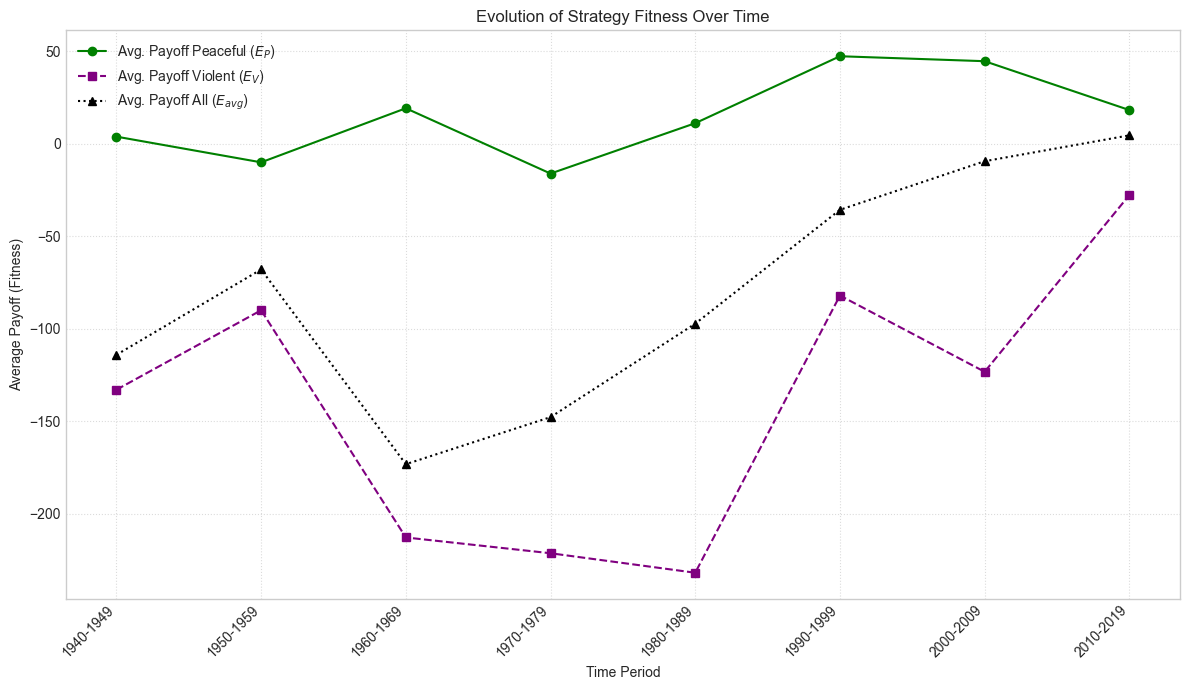

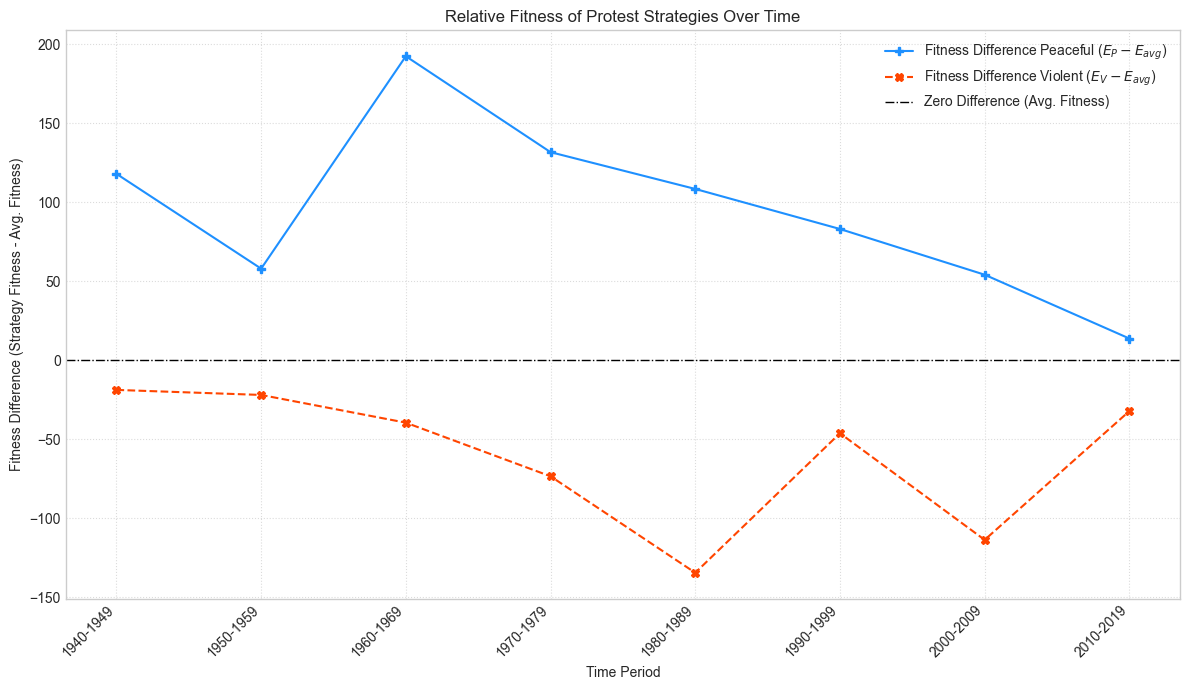

In [52]:
# Make sure temporal_df is sorted by time_period if it's not already
# If time_period is like '1940-1949', string sort usually works.
# If it's categorical and not ordered, you might need:
# temporal_df['time_period'] = pd.Categorical(temporal_df['time_period'], categories=sorted_unique_periods, ordered=True)
# temporal_df = temporal_df.sort_values('time_period')

if not temporal_df.empty:
    time_periods = temporal_df["time_period"]

    # Plot 1: Strategy Frequencies Over Time
    # Option A: Line Plot (your current approach)
    plt.figure(figsize=(12, 7))
    plt.plot(
        time_periods,
        temporal_df["x_P_t"],
        marker="o",
        linestyle="-",
        label="Proportion Peaceful ($x_P$)", # Using LaTeX
        color="blue",
    )
    plt.plot(
        time_periods,
        temporal_df["x_V_t"],
        marker="s",
        linestyle="--",
        label="Proportion Violent ($x_V$)", # Using LaTeX
        color="red",
    )
    plt.ylabel("Proportion of Campaigns")
    plt.xlabel("Time Period")
    plt.title("Evolution of Protest Strategy Frequencies Over Time")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1) # Assuming proportions sum to 1
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot 2: Payoffs (Fitness) Over Time
    plt.figure(figsize=(12, 7))
    plt.plot(
        time_periods,
        temporal_df["E_P_t"],
        marker="o",
        linestyle="-",
        label="Avg. Payoff Peaceful ($E_P$)", # Using LaTeX
        color="green",
    )
    plt.plot(
        time_periods,
        temporal_df["E_V_t"],
        marker="s",
        linestyle="--",
        label="Avg. Payoff Violent ($E_V$)", # Using LaTeX
        color="purple",
    )
    plt.plot(
        time_periods,
        temporal_df["E_avg_t"],
        marker="^",
        linestyle=":",
        label="Avg. Payoff All ($E_{avg}$)", # Using LaTeX
        color="black",
    )
    plt.ylabel("Average Payoff (Fitness)")
    plt.xlabel("Time Period")
    plt.title("Evolution of Strategy Fitness Over Time")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot 3: Fitness Differences Over Time (Line Plot for both N and V)
    plt.figure(figsize=(12, 7))
    plt.plot(
        time_periods,
        temporal_df["fitness_diff_P"],
        marker="P", # Plus marker
        linestyle="-",
        label="Fitness Difference Peaceful ($E_P - E_{avg}$)", # Using LaTeX
        color="dodgerblue",
    )
    plt.plot(
        time_periods,
        temporal_df["fitness_diff_V"], # Plotting fitness_diff_V
        marker="X", # X marker
        linestyle="--",
        label="Fitness Difference Violent ($E_V - E_{avg}$)", # Using LaTeX
        color="orangered",
    )
    plt.axhline(0, color="black", linestyle="-.", lw=1, label="Zero Difference (Avg. Fitness)")
    plt.ylabel("Fitness Difference (Strategy Fitness - Avg. Fitness)")
    plt.xlabel("Time Period")
    plt.title("Relative Fitness of Protest Strategies Over Time")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("\nTemporal summary DataFrame is empty. Cannot generate plots.")
    print(
        "This might be due to a very small sample size or issues with time binning."
    )

### Interpreting the Replicator Dynamics Plots

The following plots visualize the temporal evolution of protest strategies based on replicator dynamics.

**1. Evolution of Protest Strategy Frequencies Over Time (Line Plot & Stacked Area)**

*   **What it shows:** These plots illustrate how the proportion of "Predominantly Peaceful" (\(x_N\)) and "Predominantly Violent" (\(x_V\)) protest campaigns has changed across different decades. The line plot shows individual trends, while the stacked area chart shows their relative contributions to the total, summing to 1 (or 100%).
*   **Axes:**
    *   **X-axis (Time Period):** Decades, representing distinct periods of observation.
    *   **Y-axis (Proportion of Campaigns):** The fraction of total campaigns in a given decade that were classified as either peaceful or violent.
*   **Interpretation:**
    *   **Rising line for \(x_N\):** Indicates an increase in the prevalence of peaceful protests in that decade.
    *   **Falling line for \(x_N\):** Indicates a decrease in the prevalence of peaceful protests.
    *   **Inverse for \(x_V\):** Since there are only two strategies, a rise in one typically means a fall in the other.
    *   **Stacked Area:** The width of each colored band shows the proportion of that strategy. Changes in band width over time indicate shifts in strategy dominance.
*   **Insights:** Observe which strategy becomes more or less common over time. This provides an empirical overview of the strategic landscape's evolution. For example, if \(x_N\) generally trends upwards, it suggests peaceful strategies have become more frequent.

**2. Evolution of Strategy Fitness (Average Payoffs) Over Time**

*   **What it shows:** This plot tracks the average payoff (fitness) for peaceful strategies (\(E_{N,t}\)), violent strategies (\(E_{V,t}\)), and the overall average payoff across all campaigns (\(E_{\text{avg},t}\)) for each decade.
*   **Axes:**
    *   **X-axis (Time Period):** Decades.
    *   **Y-axis (Average Payoff (Fitness)):** The calculated average utility for protesters adopting a given strategy in that decade. Higher values mean better outcomes on average.
*   **Interpretation:**
    *   **Line for \(E_{N,t}\):** Shows how the average success/outcome of peaceful protests has changed.
    *   **Line for \(E_{V,t}\):** Shows how the average success/outcome of violent protests has changed.
    *   **Line for \(E_{\text{avg},t}\):** Represents the population average fitness.
    *   **Comparison:** If \(E_{N,t}\) is consistently above \(E_{V,t}\), peaceful protests yielded better average outcomes during those periods.
*   **Insights:** This helps understand *why* strategy frequencies might be changing. Strategies with higher average payoffs are expected to become more prevalent under replicator dynamics.

**3. Relative Fitness of Protest Strategies Over Time**

*   **What it shows:** This plot displays the *difference* between the average payoff of each strategy and the overall average payoff for each decade. Specifically, it shows \(E_{N,t} - E_{\text{avg},t}\) (fitness difference for non-violent) and \(E_{V,t} - E_{\text{avg},t}\) (fitness difference for violent).
*   **Axes:**
    *   **X-axis (Time Period):** Decades.
    *   **Y-axis (Fitness Difference):** How much better or worse a strategy performed compared to the average.
    *   **Zero Line:** Represents the average fitness. Points above this line indicate a strategy performed better than average; points below indicate worse than average.
*   **Interpretation:**
    *   **Positive Fitness Difference (e.g., for \(E_N - E_{\text{avg}}\)):** Peaceful strategies were, on average, more successful (fitter) than the typical campaign in that decade. Replicator dynamics predict that strategies with positive fitness differences should increase in proportion.
    *   **Negative Fitness Difference:** The strategy was less successful than average. Replicator dynamics predict such strategies should decrease.
*   **Insights:** This plot directly visualizes the selection pressure. If `fitness_diff_N` is consistently positive, it provides a strong EGT-based explanation for an observed increase in \(x_N\). The magnitude of the difference indicates the strength of this pressure.

In [53]:
# Assuming temporal_df is already created and contains:
# 'time_period', 'x_N_t', 'x_V_t', 'E_N_t', 'E_V_t', 'E_avg_t'
# and by extension, 'fitness_diff_N' and 'fitness_diff_V' could be used.

change_comparison_df_scaled_both = pd.DataFrame() # Initialize

if not temporal_df.empty and len(temporal_df) > 1:
    comparison_list_scaled_both = []
    for i in range(len(temporal_df) - 1):
        current_period_data = temporal_df.iloc[i]
        next_period_data = temporal_df.iloc[i+1]

        time_period_t = current_period_data["time_period"]

        # Common term
        E_avg_at_t = current_period_data["E_avg_t"]

        # --- Non-Violent (N) Strategy ---
        x_P_at_t = current_period_data["x_P_t"]
        E_P_at_t = current_period_data["E_P_t"]
        
        # Term from continuous replicator dynamics equation
        original_pred_factor_P = x_P_at_t * (E_P_at_t - E_avg_at_t)
        
        predicted_delta_xP_discrete = 0.0 # Default
        if E_avg_at_t != 0:
            predicted_delta_xP_discrete = x_P_at_t * (
                (E_P_at_t - E_avg_at_t) / abs(E_avg_at_t)
            )
        else: # Handle division by zero if E_avg_t is 0
            # If E_avg is 0, sign of (E_N - E_avg) determines direction.
            # Magnitude is undefined or infinite in this simple scaling.
            # We can use np.sign to indicate direction if E_N != E_avg
            if E_P_at_t > E_avg_at_t: predicted_delta_xP_discrete = float('inf')
            elif E_P_at_t < E_avg_at_t: predicted_delta_xP_discrete = float('-inf')
            # If E_N == E_avg == 0, then predicted change is 0.

        x_P_at_t_plus_1 = next_period_data["x_P_t"]
        actual_change_P = x_P_at_t_plus_1 - x_P_at_t

        # --- Violent (V) Strategy ---
        x_V_at_t = current_period_data["x_V_t"]
        E_V_at_t = current_period_data["E_V_t"]

        # Term from continuous replicator dynamics equation
        original_pred_factor_V = x_V_at_t * (E_V_at_t - E_avg_at_t)

        predicted_delta_xV_discrete = 0.0 # Default
        if E_avg_at_t != 0:
            predicted_delta_xV_discrete = x_V_at_t * (
                (E_V_at_t - E_avg_at_t) / abs(E_avg_at_t)
            )
        else: # Handle division by zero
            if E_V_at_t > E_avg_at_t: predicted_delta_xV_discrete = float('inf')
            elif E_V_at_t < E_avg_at_t: predicted_delta_xV_discrete = float('-inf')

        x_V_at_t_plus_1 = next_period_data["x_V_t"]
        actual_change_V = x_V_at_t_plus_1 - x_V_at_t
        # Note: In a two-strategy system, actual_change_V should be -actual_change_N

        comparison_list_scaled_both.append({
            "Period (t)": time_period_t,
            "Original Pred. Factor P": original_pred_factor_P,
            "Predicted Δx_P (Discrete)": predicted_delta_xP_discrete,
            "Actual Δx_P": actual_change_P,
            "Original Pred. Factor V": original_pred_factor_V,
            "Predicted Δx_V (Discrete)": predicted_delta_xV_discrete,
            "Actual Δx_V": actual_change_V,
        })

    change_comparison_df_scaled_both = pd.DataFrame(comparison_list_scaled_both)
    
    print("\nComparison with Scaled Predicted Change (Discrete Model) for P and V:")
    display(change_comparison_df_scaled_both.head())
    print("\nNote: 'Predicted Δx (Discrete Model)' is x_i * ( (E_i - E_avg) / |E_avg| )")
    print("      'Original Pred. Factor' is x_i * (E_i - E_avg)")

else:
    print(
        "\nTemporal summary DataFrame is empty or has less than two periods."
        " Cannot create change comparison."
    )


Comparison with Scaled Predicted Change (Discrete Model) for P and V:


,Period (t),Original Pred. Factor P,Predicted Δx_P (Discrete),Actual Δx_P,Original Pred. Factor V,Predicted Δx_V (Discrete),Actual Δx_V
0,1940-1949,16.263496,0.142524,0.137931,-16.263496,-0.142524,-0.137931
1,1950-1959,15.967776,0.234922,-0.105130,-15.967776,-0.234922,0.105130
2,1960-1969,32.838043,0.189587,0.187759,-32.838043,-0.189587,-0.187759
3,1970-1979,47.185012,0.319294,0.195563,-47.185012,-0.319294,-0.195563
4,1980-1989,60.023165,0.617063,-0.195845,-60.023165,-0.617063,0.195845



Note: 'Predicted Δx (Discrete Model)' is x_i * ( (E_i - E_avg) / |E_avg| )
      'Original Pred. Factor' is x_i * (E_i - E_avg)


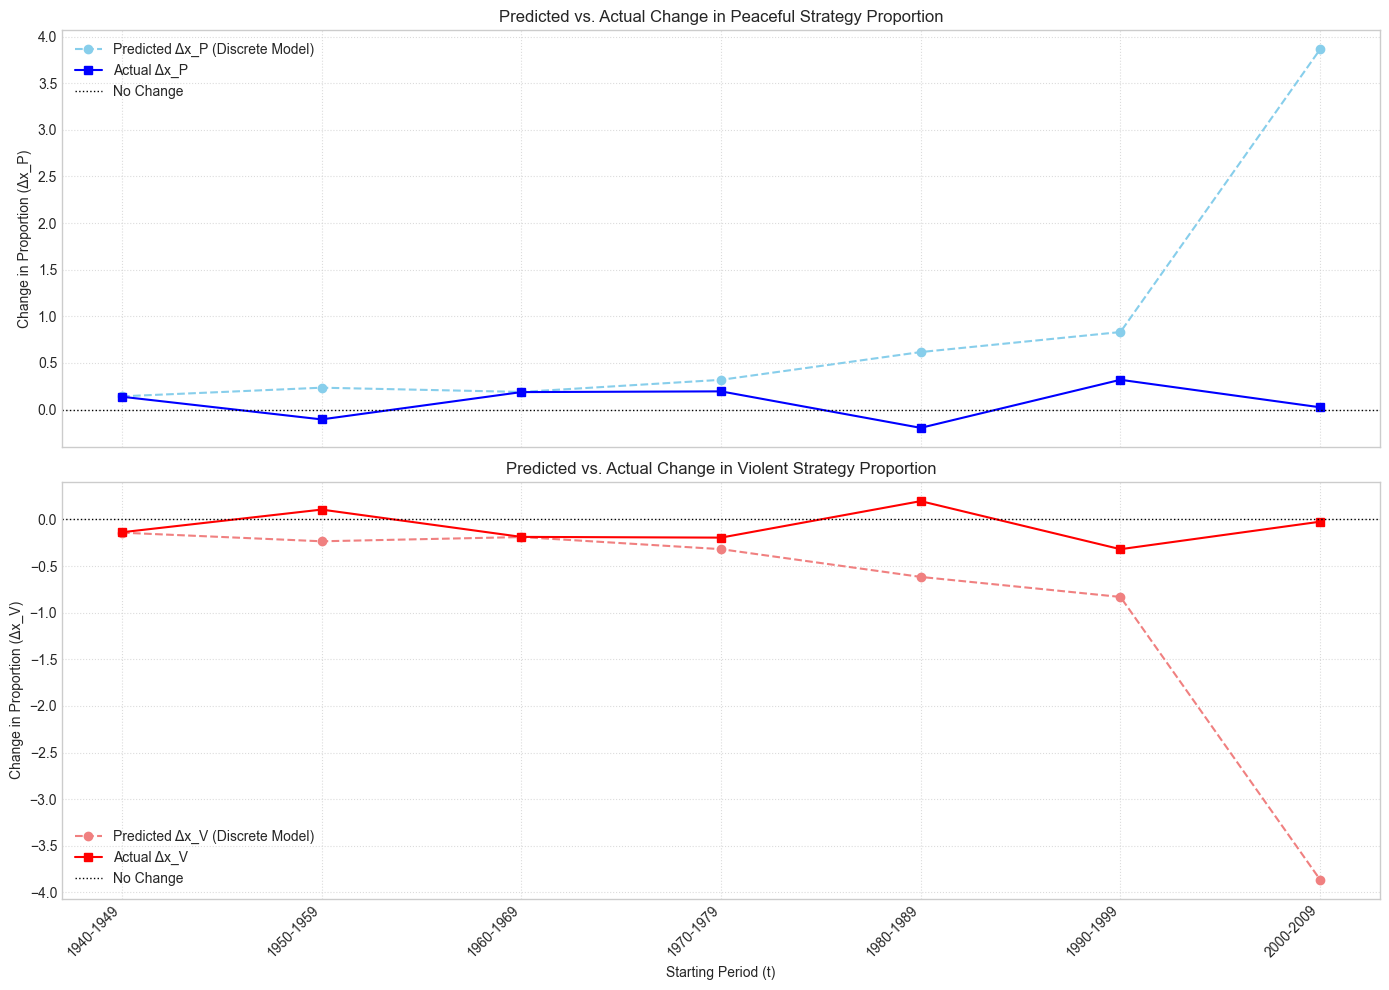

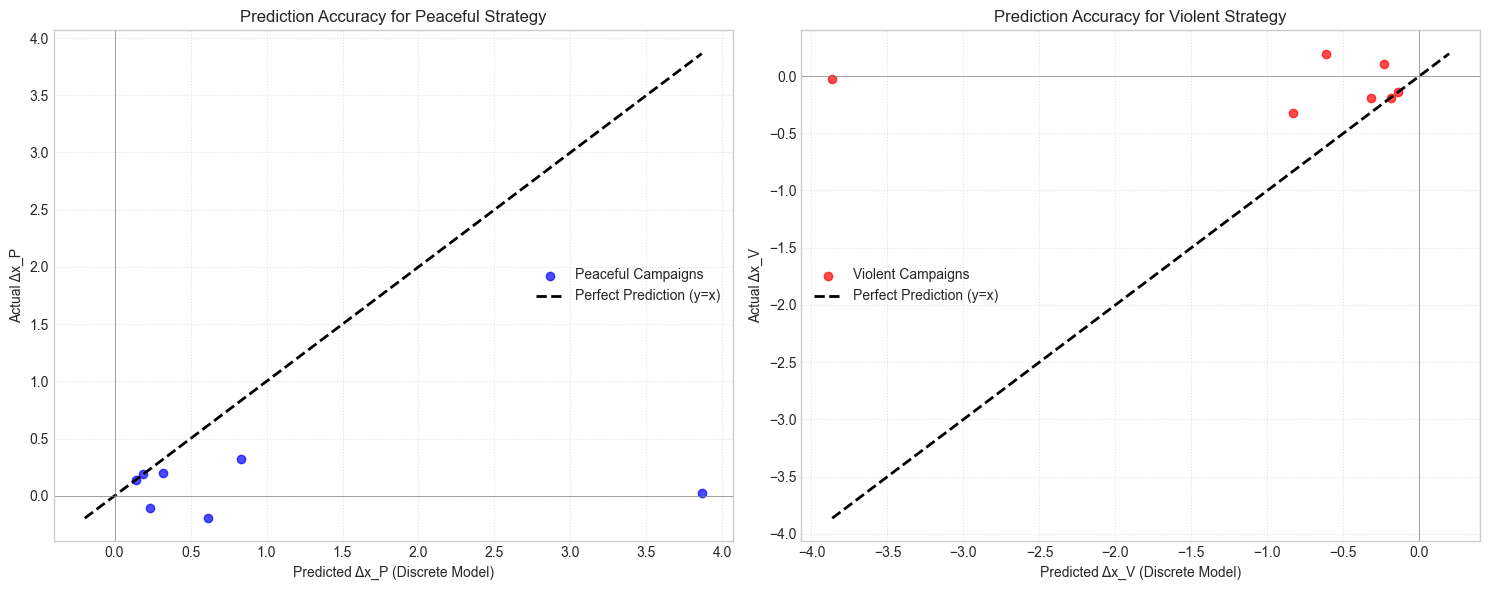

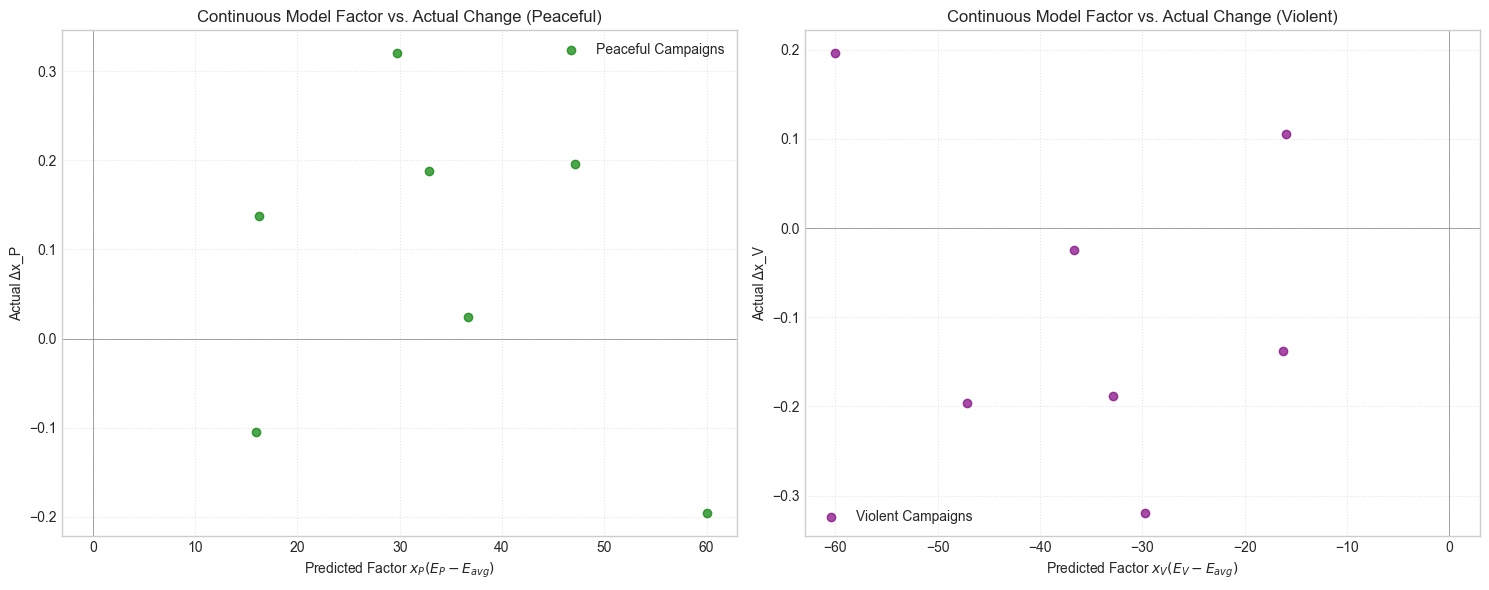

In [54]:
import matplotlib.pyplot as plt

if not change_comparison_df_scaled_both.empty:
    periods = change_comparison_df_scaled_both["Period (t)"]

    # --- Plot A: Line Plots of Predicted vs. Actual Change Over Time ---
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Subplot for Non-Violent (N)
    axes[0].plot(
        periods,
        change_comparison_df_scaled_both["Predicted Δx_P (Discrete)"],
        marker="o",
        linestyle="--",
        label="Predicted Δx_P (Discrete Model)",
        color="skyblue",
    )
    axes[0].plot(
        periods,
        change_comparison_df_scaled_both["Actual Δx_P"],
        marker="s",
        linestyle="-",
        label="Actual Δx_P",
        color="blue",
    )
    axes[0].axhline(0, color="black", linestyle=":", lw=1, label="No Change")
    axes[0].set_ylabel("Change in Proportion (Δx_P)")
    axes[0].set_title("Predicted vs. Actual Change in Peaceful Strategy Proportion")
    axes[0].legend()
    axes[0].grid(True, linestyle=":", alpha=0.7)

    # Subplot for Violent (V)
    axes[1].plot(
        periods,
        change_comparison_df_scaled_both["Predicted Δx_V (Discrete)"],
        marker="o",
        linestyle="--",
        label="Predicted Δx_V (Discrete Model)",
        color="lightcoral", # Different color for V
    )
    axes[1].plot(
        periods,
        change_comparison_df_scaled_both["Actual Δx_V"],
        marker="s",
        linestyle="-",
        label="Actual Δx_V",
        color="red", # Different color for V
    )
    axes[1].axhline(0, color="black", linestyle=":", lw=1, label="No Change")
    axes[1].set_ylabel("Change in Proportion (Δx_V)")
    axes[1].set_xlabel("Starting Period (t)")
    axes[1].set_title("Predicted vs. Actual Change in Violent Strategy Proportion")
    axes[1].legend()
    axes[1].grid(True, linestyle=":", alpha=0.7)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


    # --- Plot B: Scatter Plots of Predicted vs. Actual Change ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

    # Scatter for Non-Violent (N)
    predicted_N = change_comparison_df_scaled_both["Predicted Δx_P (Discrete)"]
    actual_N = change_comparison_df_scaled_both["Actual Δx_P"]
    axes[0].scatter(
        predicted_N,
        actual_N,
        alpha=0.7,
        color="blue",
        label="Peaceful Campaigns"
    )
    min_val_N = min(predicted_N.min(), actual_N.min())
    max_val_N = max(predicted_N.max(), actual_N.max())
    axes[0].plot([min_val_N, max_val_N], [min_val_N, max_val_N], 'k--', lw=2, label="Perfect Prediction (y=x)")
    axes[0].set_xlabel("Predicted Δx_P (Discrete Model)")
    axes[0].set_ylabel("Actual Δx_P")
    axes[0].set_title("Prediction Accuracy for Peaceful Strategy")
    axes[0].legend()
    axes[0].grid(True, linestyle=":", alpha=0.5)
    axes[0].axhline(0, color='gray', linestyle='-', lw=0.5)
    axes[0].axvline(0, color='gray', linestyle='-', lw=0.5)


    # Scatter for Violent (V)
    predicted_V = change_comparison_df_scaled_both["Predicted Δx_V (Discrete)"]
    actual_V = change_comparison_df_scaled_both["Actual Δx_V"]
    axes[1].scatter(
        predicted_V,
        actual_V,
        alpha=0.7,
        color="red",
        label="Violent Campaigns"
    )
    min_val_V = min(predicted_V.min(), actual_V.min())
    max_val_V = max(predicted_V.max(), actual_V.max())
    axes[1].plot([min_val_V, max_val_V], [min_val_V, max_val_V], 'k--', lw=2, label="Perfect Prediction (y=x)")
    axes[1].set_xlabel("Predicted Δx_V (Discrete Model)")
    axes[1].set_ylabel("Actual Δx_V")
    axes[1].set_title("Prediction Accuracy for Violent Strategy")
    axes[1].legend()
    axes[1].grid(True, linestyle=":", alpha=0.5)
    axes[1].axhline(0, color='gray', linestyle='-', lw=0.5)
    axes[1].axvline(0, color='gray', linestyle='-', lw=0.5)

    plt.tight_layout()
    plt.show()

    # --- Optional Plot C: "Original Predicted Factor" vs. Actual Change ---
    # This compares the term from the continuous replicator equation x_i*(E_i - E_avg)
    # with the actual discrete change.
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Scatter for Non-Violent (N) - Continuous Factor
    original_factor_N = change_comparison_df_scaled_both["Original Pred. Factor P"]
    # actual_N is the same as above
    axes[0].scatter(
        original_factor_N,
        actual_N,
        alpha=0.7,
        color="green",
        label="Peaceful Campaigns"
    )
    axes[0].set_xlabel("Predicted Factor $x_P(E_P - E_{avg})$") # LaTeX
    axes[0].set_ylabel("Actual Δx_P")
    axes[0].set_title("Continuous Model Factor vs. Actual Change (Peaceful)")
    axes[0].legend()
    axes[0].grid(True, linestyle=":", alpha=0.5)
    axes[0].axhline(0, color='gray', linestyle='-', lw=0.5)
    axes[0].axvline(0, color='gray', linestyle='-', lw=0.5)

    # Scatter for Violent (V) - Continuous Factor
    original_factor_V = change_comparison_df_scaled_both["Original Pred. Factor V"]
    # actual_V is the same as above
    axes[1].scatter(
        original_factor_V,
        actual_V,
        alpha=0.7,
        color="purple",
        label="Violent Campaigns"
    )
    axes[1].set_xlabel("Predicted Factor $x_V(E_V - E_{avg})$") # LaTeX
    axes[1].set_ylabel("Actual Δx_V")
    axes[1].set_title("Continuous Model Factor vs. Actual Change (Violent)")
    axes[1].legend()
    axes[1].grid(True, linestyle=":", alpha=0.5)
    axes[1].axhline(0, color='gray', linestyle='-', lw=0.5)
    axes[1].axvline(0, color='gray', linestyle='-', lw=0.5)

    plt.tight_layout()
    plt.show()

else:
    print(
        "\n'change_comparison_df_scaled_both' is empty."
        " Cannot generate comparison plots."
    )

### Interpreting the Predicted vs. Actual Change in Strategy Proportions

These plots assess how well a simple discrete-time replicator dynamics model predicts the observed changes in the proportion of non-violent (\(x_N\)) and violent (\(x_V\)) strategies from one decade to the next.

**1. Line Plots of Predicted vs. Actual Change Over Time (for \(x_N\) and \(x_V\))**

*   **What it shows:** These plots compare the "Predicted \(\Delta x_N\)" (or \(\Delta x_V\)) based on the model \(x_{i,t} \frac{E_{i,t} - E_{\text{avg},t}}{|E_{\text{avg},t}|}\) against the "Actual \(\Delta x_N = x_{N,t+1} - x_{N,t}\)" observed in the data for each inter-decade transition.
*   **Axes:**
    *   **X-axis (Starting Period (t)):** The initial decade of the transition.
    *   **Y-axis (Change in Proportion (\(\Delta x_N\) or \(\Delta x_V\))):** The change in the strategy's proportion.
*   **Interpretation:**
    *   **Agreement:** If the "Predicted" and "Actual" lines move in the same direction (both positive or both negative), the model correctly predicts the direction of change.
    *   **Magnitude:** The closeness of the lines indicates how well the model predicts the *magnitude* of change.
    *   **Disagreements:** Periods where the lines move in opposite directions or where one is zero and the other is not, highlight limitations of this simple model or suggest other factors at play.
*   **Insights:** This helps evaluate the model's explanatory power. Consistent directional agreement is a good sign. Disagreements can point to specific historical periods where the simple fitness-based dynamic might be insufficient.

**2. Scatter Plots of Predicted vs. Actual Change (for \(x_N\) and \(x_V\))**

*   **What it shows:** Each point represents an inter-decade transition. The x-coordinate is the predicted change in strategy proportion, and the y-coordinate is the actual observed change.
*   **Axes:**
    *   **X-axis (Predicted \(\Delta x_N\) or \(\Delta x_V\)):** Change predicted by the model.
    *   **Y-axis (Actual \(\Delta x_N\) or \(\Delta x_V\)):** Change observed in the data.
    *   **Diagonal Line (y=x):** Represents perfect prediction. Points on this line mean predicted change equals actual change.
    *   **Quadrants:**
        *   Top-Right: Model predicts increase, actual was increase (agreement).
        *   Bottom-Left: Model predicts decrease, actual was decrease (agreement).
        *   Top-Left: Model predicts decrease, actual was increase (disagreement).
        *   Bottom-Right: Model predicts increase, actual was decrease (disagreement).
*   **Interpretation:**
    *   **Clustering around y=x:** Indicates good model performance.
    *   **Points in agreement quadrants:** Show where the model's directional prediction was correct.
    *   **Points in disagreement quadrants:** Highlight model failures.
*   **Insights:** Provides a visual summary of the model's predictive accuracy across all periods. The spread of points indicates the consistency of the model's performance.

**3. Scatter Plots of "Original Predicted Factor" vs. Actual Change (for \(x_N\) and \(x_V\))**

*   **What it shows:** This plot compares the raw replicator term \(x_i(E_i - E_{\text{avg}})\) (which determines the sign and unscaled magnitude of change in the continuous replicator equation) against the actual discrete change \(\Delta x_i\).
*   **Axes:**
    *   **X-axis (Predicted Factor \(x_i(E_i - E_{\text{avg}})\)):** The unscaled factor from replicator dynamics.
    *   **Y-axis (Actual \(\Delta x_N\) or \(\Delta x_V\)):** Change observed in the data.
*   **Interpretation:**
    *   The primary focus here is on directional agreement. If the Predicted Factor is positive, we expect Actual \(\Delta x_i\) to be positive, and vice-versa.
    *   Points in the top-right and bottom-left quadrants indicate directional agreement.
*   **Insights:** This helps assess if the core mechanism of replicator dynamics (strategies with above-average fitness increase) holds, even if the specific scaling used for "Predicted \(\Delta x_N\)" in the previous plots isn't perfect.


In [55]:
# Assuming temporal_df is already created and contains:
# 'time_period', 'x_P_t', 'x_V_t' (and other EGT metrics)
# Ensure temporal_df is sorted by time_period if it's not already.
# If 'time_period' is categorical, ensure it's ordered.
# Example:
# if pd.api.types.is_categorical_dtype(temporal_df['time_period']) and not temporal_df['time_period'].cat.ordered:
#     sorted_categories = sorted(temporal_df['time_period'].unique())
#     temporal_df['time_period'] = pd.Categorical(temporal_df['time_period'], categories=sorted_categories, ordered=True)
# temporal_df = temporal_df.sort_values('time_period')


phase_data_list = []
if not temporal_df.empty and len(temporal_df) > 1:
    for i in range(len(temporal_df) - 1):
        current_period_data = temporal_df.iloc[i]
        next_period_data = temporal_df.iloc[i+1]

        x_P_at_t = current_period_data["x_P_t"]
        actual_delta_x_N = next_period_data["x_P_t"] - x_P_at_t
        
        # For completeness, though phase plot usually focuses on one strategy's proportion
        x_V_at_t = current_period_data["x_V_t"]
        actual_delta_x_V = next_period_data["x_V_t"] - x_V_at_t


        phase_data_list.append(
            {
                "Period (t)": current_period_data["time_period"],
                "x_P(t)": x_P_at_t,
                "Actual Δx_P": actual_delta_x_N,
                "x_V(t)": x_V_at_t,
                "Actual Δx_V": actual_delta_x_V,
            }
        )
    phase_data_df = pd.DataFrame(phase_data_list)
    print("\nData for Phase Plot and 1D Direction Field:")
    display(phase_data_df.head())
else:
    phase_data_df = pd.DataFrame() # Ensure it's an empty DataFrame
    print(
        "\nTemporal summary DataFrame is empty or has less than two periods."
        " Cannot create data for phase plot."
    )


Data for Phase Plot and 1D Direction Field:


,Period (t),x_P(t),Actual Δx_P,x_V(t),Actual Δx_V
0,1940-1949,0.137931,0.137931,0.862069,-0.137931
1,1950-1959,0.275862,-0.105130,0.724138,0.105130
2,1960-1969,0.170732,0.187759,0.829268,-0.187759
3,1970-1979,0.358491,0.195563,0.641509,-0.195563
4,1980-1989,0.554054,-0.195845,0.445946,0.195845


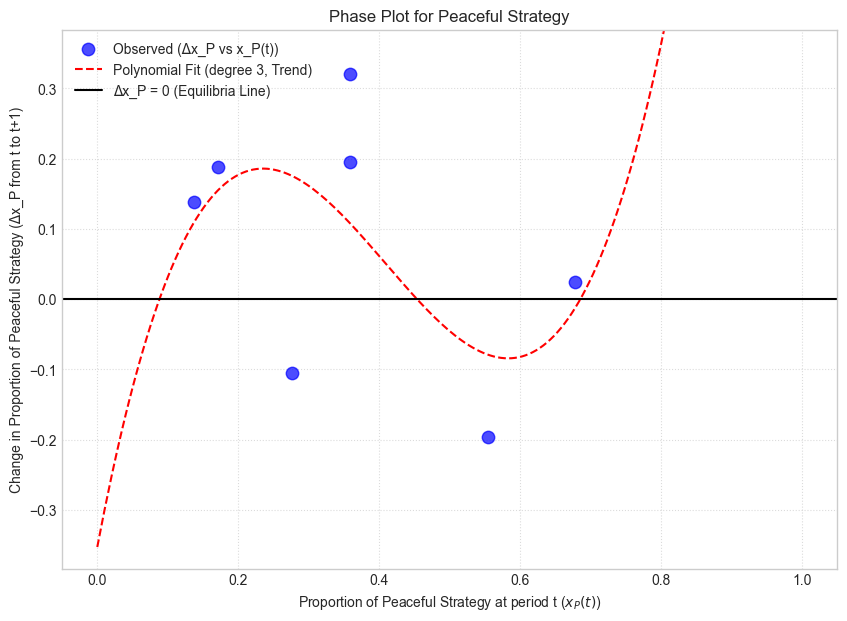

In [56]:
if not phase_data_df.empty:
    plt.figure(figsize=(10, 7))

    x_P_values = phase_data_df["x_P(t)"]
    delta_x_P_values = phase_data_df["Actual Δx_P"]

    plt.scatter(
        x_P_values,
        delta_x_P_values,
        color="blue",
        alpha=0.7,
        label="Observed (Δx_P vs x_P(t))",
        s=80, # Slightly larger markers
    )

    # Optional: Fit a curve (e.g., polynomial) to visualize the trend
    # This can help in identifying where the curve crosses Δx_N = 0
    if len(x_P_values) >= 3:  # Need enough points for a meaningful fit
        try:
            # Sort values for smooth line plotting
            sorted_indices = np.argsort(x_P_values)
            x_P_sorted = x_P_values.iloc[sorted_indices]
            delta_x_P_sorted_for_fit = delta_x_P_values.iloc[sorted_indices]

            # Fit polynomial (e.g., degree 2 or 3).
            # The replicator equation for 2 strategies often leads to a cubic for Δx.
            degree_to_fit = min(3, len(x_P_values) - 1) # Adjust degree based on points
            if degree_to_fit > 0:
                coeffs = np.polyfit(x_P_sorted, delta_x_P_sorted_for_fit, degree_to_fit)
                poly_func = np.poly1d(coeffs)
                x_P_fit_range = np.linspace(min(0,x_P_values.min()), max(1,x_P_values.max()), 200)
                delta_x_P_fitted = poly_func(x_P_fit_range)
                plt.plot(
                    x_P_fit_range,
                    delta_x_P_fitted,
                    color="red",
                    linestyle="--",
                    label=f"Polynomial Fit (degree {degree_to_fit}, Trend)",
                )
        except Exception as e:
            print(f"Could not fit polynomial for phase plot: {e}")

    plt.axhline(
        0, color="black", linestyle="-", lw=1.5, label="Δx_P = 0 (Equilibria Line)"
    )
    plt.xlabel("Proportion of Peaceful Strategy at period t ($x_P(t)$)")
    plt.ylabel("Change in Proportion of Peaceful Strategy (Δx_P from t to t+1)")
    plt.title("Phase Plot for Peaceful Strategy")
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.xlim(-0.05, 1.05)  # x_N is between 0 and 1

    # Dynamic Y-limits based on data
    if not delta_x_P_values.empty:
        max_abs_delta = delta_x_P_values.abs().max()
        if pd.notna(max_abs_delta) and max_abs_delta > 0:
            plt.ylim(-max_abs_delta * 1.2, max_abs_delta * 1.2)
        else:
            plt.ylim(-0.1, 0.1) # Default if no change or single point
    else:
        plt.ylim(-0.1, 0.1)


    plt.show()
else:
    print("\nPhase plot data is empty. Cannot generate phase plot.")

**4. Phase Plot for Non-Violent Strategy (\(\Delta x_N\) vs. \(x_N(t)\))**

*   **What it shows:** This plot visualizes the change in the proportion of non-violent strategy (\(\Delta x_N\)) as a function of its current proportion (\(x_N(t)\)). Each point represents a decade's \(x_N(t)\) and the subsequent change to \(x_N(t+1)\).
*   **Axes:**
    *   **X-axis (\(x_N(t)\)):** Proportion of non-violent strategy at time \(t\) (ranging from 0 to 1).
    *   **Y-axis (\(\Delta x_N\)):** Change in the proportion of non-violent strategy from \(t\) to \(t+1\).
    *   **Horizontal Line at \(\Delta x_N = 0\):** Represents equilibrium points. If the system is at a value of \(x_N\) where \(\Delta x_N = 0\), the proportion of non-violent strategy is predicted not to change.
*   **Interpretation:**
    *   **Points above \(\Delta x_N = 0\):** \(x_N\) is increasing.
    *   **Points below \(\Delta x_N = 0\):** \(x_N\) is decreasing.
    *   **Intersections with \(\Delta x_N = 0\):** Indicate potential equilibria.
        *   If the fitted curve (or trend of points) crosses from positive \(\Delta x_N\) to negative \(\Delta x_N\) as \(x_N\) increases, it suggests a stable equilibrium around the crossing point.
        *   If it crosses from negative to positive, it suggests an unstable equilibrium.
    *   **Boundary Equilibria:** \(x_N=0\) (all violent) and \(x_N=1\) (all peaceful) are always potential equilibria. If \(\Delta x_N > 0\) near \(x_N=0\), then \(x_N=0\) is unstable. If \(\Delta x_N < 0\) near \(x_N=1\), then \(x_N=1\) is unstable.
*   **Insights:** Helps identify the dynamic trajectory of the system and potential long-term stable states or cyclical behavior for the proportion of non-violent protests.

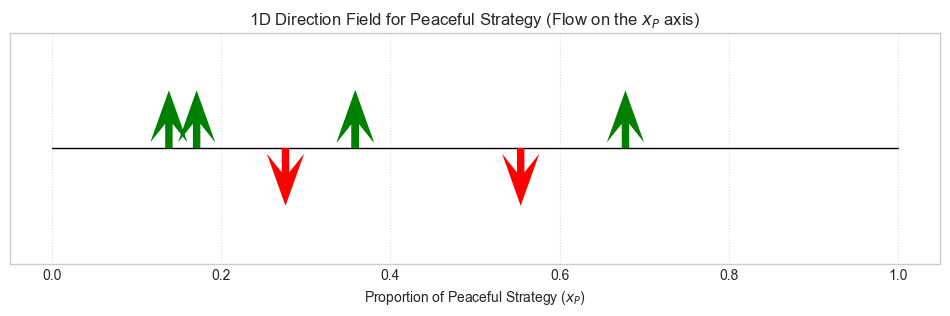

In [57]:
if not phase_data_df.empty:
    plt.figure(figsize=(12, 3)) # Wider, shorter plot

    # Plot a baseline representing the x_N axis
    plt.plot([0, 1], [0, 0], color="black", lw=1.0, zorder=1)

    # Add quiver (arrows)
    # x_coords are x_N(t)
    # y_coords are all 0 (on the axis)
    # u_coords (x-component of arrow) are 0
    # v_coords (y-component of arrow) are Δx_N
    
    x_P_at_t_vals = phase_data_df["x_P(t)"]
    delta_x_P_vals = phase_data_df["Actual Δx_P"]

    # Normalize delta_x_N_vals for consistent arrow appearance if desired,
    # or use raw values if magnitudes are important to show.
    # For this plot, direction is key. Let's scale for visibility.
    
    # Filter out zero changes for clarity of arrows, or plot them as dots
    non_zero_deltas = delta_x_P_vals != 0
    
    if non_zero_deltas.any():
        # Scale arrow lengths for better visualization, ensure they don't overlap too much
        # The 'scale' parameter in quiver adjusts arrow length: smaller scale = longer arrows
        # A unit vector in y direction scaled by sign of delta_x_N
        arrow_ys = np.sign(delta_x_P_vals[non_zero_deltas]) * 0.1 # Fixed length for direction
        
        plt.quiver(
            x_P_at_t_vals[non_zero_deltas], # X position of arrow tail
            np.zeros(non_zero_deltas.sum()),    # Y position of arrow tail (on the axis)
            np.zeros(non_zero_deltas.sum()),    # X-component of arrow (0 for vertical)
            arrow_ys,                           # Y-component of arrow (direction)
            angles="xy",
            scale_units="y", # Scale based on y-axis units
            scale=1, # Adjust scale for arrow length (1 means arrow y-component is its length in data units)
            color=np.where(delta_x_P_vals[non_zero_deltas] > 0, "green", "red"),
            width=0.008, # Arrow width
            headwidth=5,
            headlength=7,
            zorder=2
        )

    # Plot points where Δx_N is exactly 0 (if any) as distinct markers
    zero_delta_points = x_P_at_t_vals[delta_x_P_vals == 0]
    if not zero_delta_points.empty:
        plt.scatter(zero_delta_points, np.zeros(len(zero_delta_points)), color='blue', marker='o', s=100, zorder=3, label="Δx_N = 0 Points")


    plt.xlabel("Proportion of Peaceful Strategy ($x_P$)")
    plt.yticks([])  # No y-axis values needed for this representation
    plt.title("1D Direction Field for Peaceful Strategy (Flow on the $x_P$ axis)")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.2, 0.2) # Give some space for arrows
    if not zero_delta_points.empty:
        plt.legend()
    plt.grid(True, axis="x", linestyle=":", alpha=0.7)
    plt.show()
else:
    print("\nPhase plot data is empty. Cannot generate 1D direction field.")

**5. 1D Direction Field for Non-Violent Strategy (Flow on the \(x_N\) axis)**

*   **What it shows:** This plot provides a simplified view of the phase plot, showing the direction of change in \(x_N\) along the \(x_N\) axis (from 0 to 1).
*   **Axes:**
    *   **X-axis (\(x_N\)):** Proportion of non-violent strategy.
    *   **Arrows:** Indicate the direction of flow.
        *   **Green arrow pointing right:** \(\Delta x_N > 0\), so \(x_N\) tends to increase from that point.
        *   **Red arrow pointing left:** \(\Delta x_N < 0\), so \(x_N\) tends to decrease from that point.
    *   **Blue circles (if present):** Indicate points where \(\Delta x_N = 0\) (equilibria).
*   **Interpretation:**
    *   **Stable Equilibrium:** Arrows on both sides point towards it.
    *   **Unstable Equilibrium:** Arrows on both sides point away from it.
*   **Insights:** Clearly visualizes the stability of different proportions of non-violent protest. It shows where the system is expected to move towards or away from.

In [58]:
import pandas as pd
import numpy as np

def calculate_empirical_game_df(df_analyzed):
    """
    Calculates the empirical game structure DataFrame from analyzed campaign
    data.

    Args:
        df_analyzed (pd.DataFrame): DataFrame with columns:
            'time_period', 'protester_strategy', 'regime_response_mapped',
            'protester_payoff'.

    Returns:
        pd.DataFrame: empirical_game_df indexed by 'time_period' with columns
            for average payoffs, counts, and conditional probabilities.
    """
    if "time_period" not in df_analyzed.columns:
        raise KeyError(
            "Column 'time_period' not found in df_analyzed. "
            "Ensure it's created before calling this function."
        )

    # Ensure time_period is string for consistent sorting if it's like 1950, 1960
    # This logic might need adjustment based on actual 'time_period' format
    if df_analyzed["time_period"].dtype == "int64" or \
       df_analyzed["time_period"].dtype == "int32":
        if df_analyzed["time_period"].astype(str).str.match(r"^\d{4}$").all():
            df_analyzed["time_period"] = (
                df_analyzed["time_period"].astype(str) + "s"
            ) # e.g. 1950 -> 1950s
        else: # If already string like '1950-1959', convert to string
            df_analyzed["time_period"] = df_analyzed["time_period"].astype(str)
    elif not pd.api.types.is_string_dtype(df_analyzed["time_period"]):
        df_analyzed["time_period"] = df_analyzed["time_period"].astype(str)


    # Group by time_period, protester_strategy, and regime_response_mapped
    # Calculate mean payoff and count for each group
    grouped_outcomes = df_analyzed.groupby(
        ["time_period", "protester_strategy", "regime_response_mapped"],
        observed=True, # Recommended for future pandas versions
    )["protester_payoff"].agg(["mean", "count"]).reset_index()
    grouped_outcomes.rename(
        columns={"mean": "avg_payoff", "count": "n_campaigns"},
        inplace=True,
    )

    # Define all possible protester strategies and regime responses
    protester_strategies = ["p", "v"]
    regime_responses = ["f", "l", "r"] # Fully Meet, Limited Meet, Reject

    # Create a MultiIndex for all possible outcome columns
    multi_index_cols = pd.MultiIndex.from_product(
        [protester_strategies, regime_responses],
        names=["protester_strategy", "regime_response_mapped"],
    )

    # Pivot for average payoffs
    payoff_pivot = grouped_outcomes.pivot_table(
        index="time_period",
        columns=["protester_strategy", "regime_response_mapped"],
        values="avg_payoff",
    )
    # Reindex to ensure all 6 payoff columns are present (NaN if no data)
    payoff_pivot = payoff_pivot.reindex(columns=multi_index_cols)
    payoff_pivot.columns = [
        f"u_P({s},{r})" for s, r in payoff_pivot.columns
    ]

    # Pivot for counts
    count_pivot = grouped_outcomes.pivot_table(
        index="time_period",
        columns=["protester_strategy", "regime_response_mapped"],
        values="n_campaigns",
    )
    # Reindex to ensure all 6 count columns are present (0 if no data)
    count_pivot = count_pivot.reindex(columns=multi_index_cols).fillna(0).astype(int)
    count_pivot.columns = [f"N({s},{r})" for s, r in count_pivot.columns]

    # Calculate total counts for peaceful (N(p)) and violent (N(v)) protests
    for strat_label in protester_strategies:
        count_pivot[f"N({strat_label})"] = 0
        for resp_label in regime_responses:
            count_pivot[f"N({strat_label})"] += count_pivot[
                f"N({strat_label},{resp_label})"
            ]

    # Calculate conditional probabilities of regime response
    prob_df = pd.DataFrame(index=count_pivot.index)
    for strat, strat_label in [("p", "p"), ("v", "v")]:
        total_strat_campaigns = count_pivot[f"N({strat_label})"]
        for resp, resp_label in [("f", "f"), ("l", "l"), ("r", "r")]:
            col_name = f"P({resp_label}|{strat_label})"
            numerator = count_pivot[f"N({strat_label},{resp_label})"]
            # Ensure total_strat_campaigns is not zero before division
            prob_df[col_name] = np.divide(
                numerator.astype(float),
                total_strat_campaigns.astype(float),
                out=np.zeros_like(numerator, dtype=float),
                where=total_strat_campaigns != 0,
            )

    # Combine all parts into empirical_game_df
    empirical_game_df = pd.concat(
        [payoff_pivot, count_pivot, prob_df], axis=1
    )

    # Define column order for clarity
    column_order = [
        # Payoffs
        "u_P(p,f)", "u_P(p,l)", "u_P(p,r)",
        "u_P(v,f)", "u_P(v,l)", "u_P(v,r)",
        # Counts for each outcome
        "N(p,f)", "N(p,l)", "N(p,r)",
        "N(v,f)", "N(v,l)", "N(v,r)",
        # Total counts per protester strategy
        "N(p)", "N(v)",
        # Conditional probabilities
        "P(f|p)", "P(l|p)", "P(r|p)", # Corrected from P(rp)
        "P(f|v)", "P(l|v)", "P(r|v)", # Corrected from P(rlv)
    ]
    # Reindex to ensure all columns are present and in order, fill missing with NaN
    # (or 0 for counts if preferred, though NaNs are fine for payoffs/probs)
    empirical_game_df = empirical_game_df.reindex(columns=column_order)

    # Sort index if it's time-based (e.g., '1950s', '1960s' or '1950-1959')
    # This should handle string-based decades correctly
    empirical_game_df = empirical_game_df.sort_index()

    return empirical_game_df

In [59]:
def plot_empirical_game_data(empirical_game_df):
    """
    Generates plots for the empirical game data.

    Args:
        empirical_game_df (pd.DataFrame): The DataFrame generated by
            calculate_empirical_game_df.
    """
    if empirical_game_df.empty:
        print("Empirical game DataFrame is empty. Cannot generate plots.")
        return

    time_periods = empirical_game_df.index

    # Plot 1: Average Protester Payoffs Over Time
    plt.figure(figsize=(14, 7))
    payoff_cols = {
        "Peaceful, Full Success (p,f)": "u_P(p,f)",
        "Peaceful, Limited Success (p,l)": "u_P(p,l)",
        "Peaceful, Failure (p,r)": "u_P(p,r)",
        "Violent, Full Success (v,f)": "u_P(v,f)",
        "Violent, Limited Success (v,l)": "u_P(v,l)",
        "Violent, Failure (v,r)": "u_P(v,r)",
    }
    styles = ["-", "--", "dotted", "-", "--", "dotted"]
    colors = ["blue", "blue", "blue", "red", "red", "red"]
    idx = 0
    for label, col in payoff_cols.items():
        if col in empirical_game_df.columns:
            plt.plot(
                time_periods,
                empirical_game_df[col],
                marker="o",
                linestyle=styles[idx % len(styles)],
                color=colors[idx % len(colors)],
                label=label,
            )
        idx += 1
    plt.title("Average Protester Payoffs Over Time by Outcome")
    plt.xlabel("Time Period (Decade)")
    plt.ylabel(r"Average Protester Payoff ($u_P$)") # Using LaTeX
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot 2: Conditional Probabilities of Regime Response Over Time
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    # Subplot 2a: Given Peaceful Protest (p)
    prob_p_cols = {
        "P(Fully Meet | Peaceful) P(f|p)": "P(f|p)",
        "P(Limited Meet | Peaceful) P(l|p)": "P(l|p)",
        "P(Reject | Peaceful) P(r|p)": "P(r|p)",
    }
    colors_p = ["green", "orange", "purple"]
    idx = 0
    for label, col in prob_p_cols.items():
        if col in empirical_game_df.columns:
            axes[0].plot(
                time_periods,
                empirical_game_df[col],
                marker="o",
                linestyle="-", # Can vary styles if desired
                color=colors_p[idx % len(colors_p)],
                label=label,
            )
        idx += 1
    axes[0].set_title(
        "Probabilities of Regime Response Given Peaceful Protest"
    )
    axes[0].set_ylabel("Probability")
    axes[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axes[0].grid(True, linestyle=":", alpha=0.7)
    axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

    # Subplot 2b: Given Violent Protest (v)
    prob_v_cols = {
        "P(Fully Meet | Violent) P(f|v)": "P(f|v)",
        "P(Limited Meet | Violent) P(l|v)": "P(l|v)",
        "P(Reject | Violent) P(r|v)": "P(r|v)",
    }
    colors_v = ["cyan", "magenta", "brown"]
    idx = 0
    for label, col in prob_v_cols.items():
        if col in empirical_game_df.columns:
            axes[1].plot(
                time_periods,
                empirical_game_df[col],
                marker="o",
                linestyle="-", # Can vary styles if desired
                color=colors_v[idx % len(colors_v)],
                label=label,
            )
        idx += 1
    axes[1].set_title(
        "Probabilities of Regime Response Given Violent Protest"
    )
    axes[1].set_xlabel("Time Period (Decade)")
    axes[1].set_ylabel("Probability")
    axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axes[1].grid(True, linestyle=":", alpha=0.7)
    axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot 3: Number of Campaigns per Outcome Over Time
    plt.figure(figsize=(14, 7))
    count_cols = {
        "N(p,f)": "N(p,f)", "N(p,l)": "N(p,l)", "N(p,r)": "N(p,r)",
        "N(v,f)": "N(v,f)", "N(v,l)": "N(v,l)", "N(v,r)": "N(v,r)",
    }
    # Using same styles and colors as payoff plot for consistency by strategy-type
    idx = 0
    for label, col in count_cols.items():
        if col in empirical_game_df.columns:
            plt.plot(
                time_periods,
                empirical_game_df[col],
                marker="s",  # square marker for counts
                linestyle=styles[idx % len(styles)], # from payoff plot
                color=colors[idx % len(colors)],   # from payoff plot
                label=label,
            )
        idx += 1
    plt.title("Number of Campaigns Over Time by Outcome")
    plt.xlabel("Time Period (Decade)")
    plt.ylabel("Number of Campaigns")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot 4: Total Number of Peaceful vs Violent Campaigns Over Time
    plt.figure(figsize=(12, 6))
    if "N(p)" in empirical_game_df.columns:
        plt.plot(
            time_periods,
            empirical_game_df["N(p)"],
            marker="o",
            label="Total Peaceful Campaigns N(p)",
            color="green",
        )
    if "N(v)" in empirical_game_df.columns:
        plt.plot(
            time_periods,
            empirical_game_df["N(v)"],
            marker="o",
            label="Total Violent Campaigns N(v)",
            color="purple",
        )
    plt.title("Total Number of Peaceful vs. Violent Campaigns Over Time")
    plt.xlabel("Time Period (Decade)")
    plt.ylabel("Total Number of Campaigns")
    if "N(p)" in empirical_game_df.columns or "N(v)" in empirical_game_df.columns:
        plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [60]:
empirical_game_df = calculate_empirical_game_df(df_analyzed)

# Using the sample for now:
print("Empirical Game DataFrame:")
empirical_game_df.head()


Empirical Game DataFrame:


/var/folders/dm/klqwbm8j69v1rbp8zzmpls4w0000gn/T/ipykernel_46348/3618560753.py:60: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  payoff_pivot = grouped_outcomes.pivot_table(
/var/folders/dm/klqwbm8j69v1rbp8zzmpls4w0000gn/T/ipykernel_46348/3618560753.py:72: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_pivot = grouped_outcomes.pivot_table(


,"u_P(p,f)","u_P(p,l)","u_P(p,r)","u_P(v,f)","u_P(v,l)","u_P(v,r)","N(p,f)","N(p,l)","N(p,r)","N(v,f)","N(v,l)","N(v,r)",N(p),N(v),P(f|p),P(l|p),P(r|p),P(f|v),P(l|v),P(r|v)
time_period,,,,,,,,,,,,,,,,,,,,
1940-1949,33.125000,-50.950,-0.100000,-34.031250,-200.350000,-178.237500,2,1,1,8,1,16,4,25,0.500000,0.250000,0.250000,0.320000,0.040000,0.640000
1950-1959,94.400000,35.450,-49.200000,0.720000,NaN,-172.513636,1,2,5,10,0,11,8,21,0.125000,0.250000,0.625000,0.476190,0.000000,0.523810
1960-1969,83.600000,27.300,-29.300000,-164.291667,-267.464286,-208.450000,2,2,3,6,7,21,7,34,0.285714,0.285714,0.428571,0.176471,0.205882,0.617647
1970-1979,55.505000,24.675,-130.200000,0.644444,-302.130000,-301.022500,10,2,7,9,5,20,19,34,0.526316,0.105263,0.368421,0.264706,0.147059,0.588235
1980-1989,39.558696,22.210,-43.642308,-34.188889,-134.366667,-330.519048,23,5,13,9,3,21,41,33,0.560976,0.121951,0.317073,0.272727,0.090909,0.636364


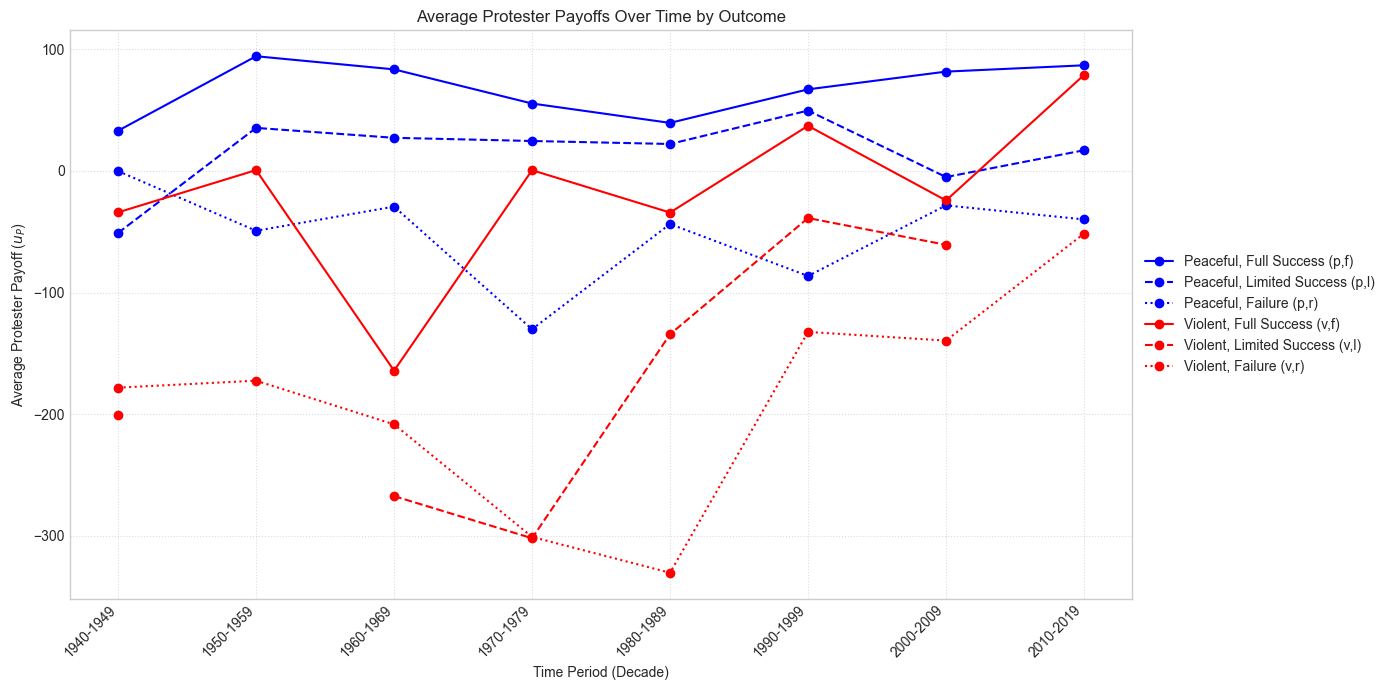

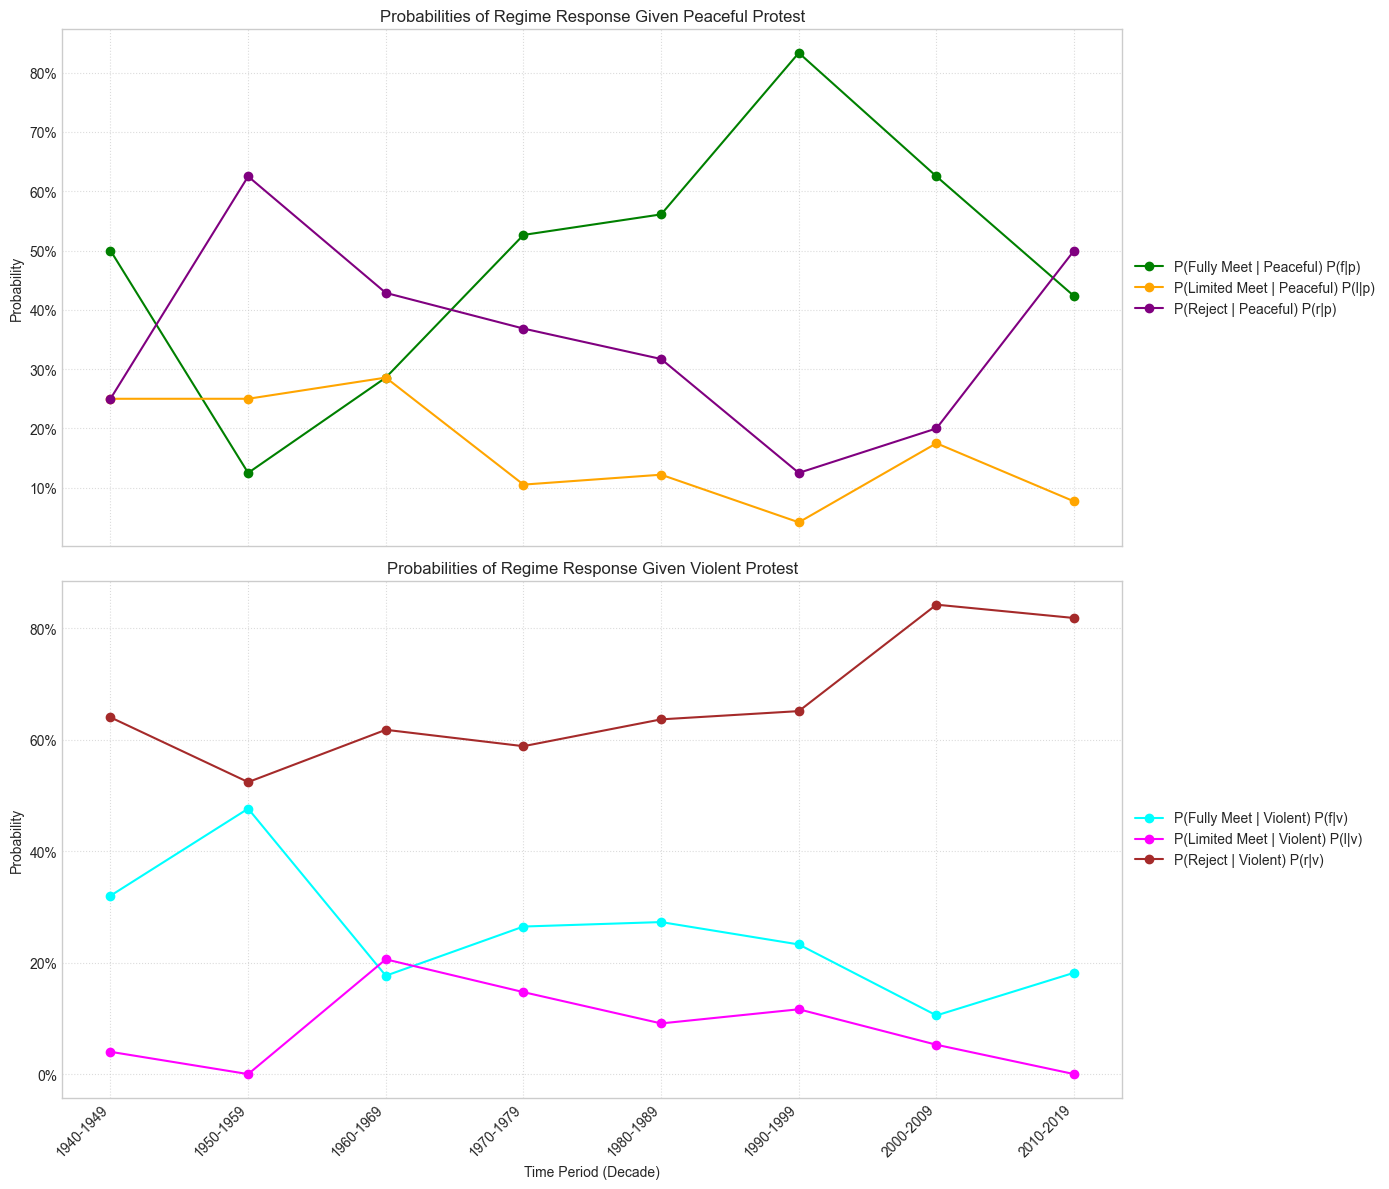

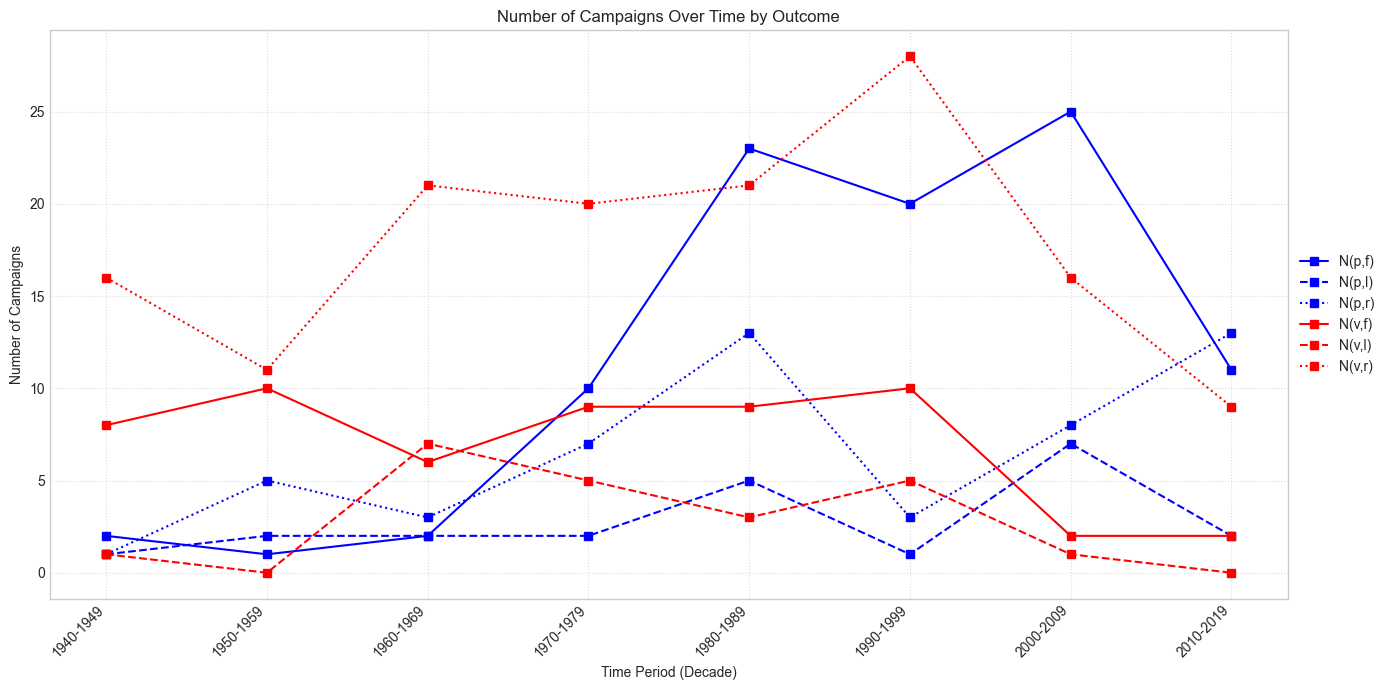

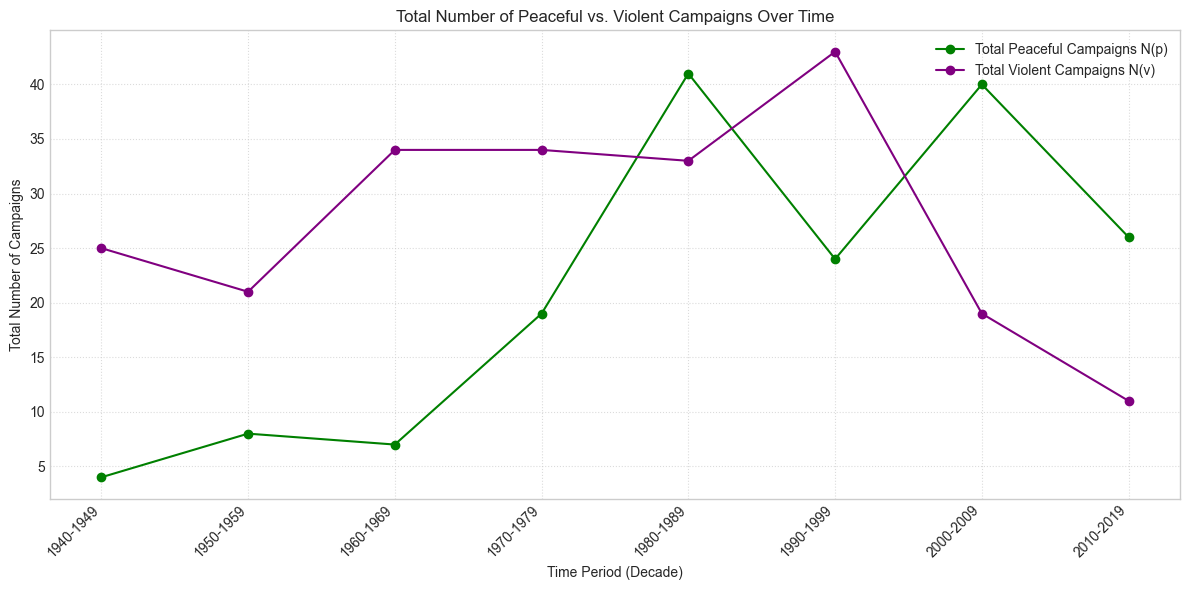

In [61]:
# Generate and display plots
plot_empirical_game_data(empirical_game_df)

### Interpreting the Empirical Game Structure Plots

These plots examine how the underlying 2x3 game (Protester strategies: Peaceful/Violent vs. Regime responses: Full Meet/Limited Meet/Reject) has manifested empirically in the data over different decades. This involves looking at average payoffs for each outcome, the frequency of those outcomes, and the conditional probabilities of regime responses.

**1. Average Protester Payoffs Over Time by Outcome**

*   **What it shows:** This plot tracks the average protester payoff (\(u_P\)) for each of the six possible outcomes (e.g., \(u_P(p,f)\) for Peaceful protest followed by Full regime concession, \(u_P(v,r)\) for Violent protest followed by Rejection) across decades.
*   **Axes:**
    *   **X-axis (Time Period (Decade)):** Decades.
    *   **Y-axis (Average Protester Payoff (\(u_P\))):** The average utility protesters received when a specific strategy-response pair occurred in that decade.
*   **Interpretation:**
    *   **Trends for each line:** Shows if a particular outcome became more or less beneficial to protesters over time. For example, if the line for \(u_P(p,f)\) trends upwards, it means peaceful protests that achieved full success yielded increasingly higher average payoffs.
    *   **Relative positions of lines:** Compares the desirability of different outcomes in any given decade. For instance, consistently seeing \(u_P(p,f)\) above \(u_P(v,f)\) would suggest that achieving full success via peaceful means was generally better than via violent means, based on your utility model.
*   **Insights:** This reveals how the "value" of each specific outcome in the game matrix has changed over time. This can influence rational protesters' strategy choices if they can anticipate these payoffs.

**2. Conditional Probabilities of Regime Response Over Time**

*   **What it shows:** Two separate subplots:
    *   **Given Peaceful Protest (p):** Shows the probability of the regime responding with Full Meet (\(P(f|p)\)), Limited Meet (\(P(l|p)\)), or Reject (\(P(r|p)\)) when protesters chose a peaceful strategy.
    *   **Given Violent Protest (v):** Shows the probability of the regime responding with Full Meet (\(P(f|v)\)), Limited Meet (\(P(l|v)\)), or Reject (\(P(r|v)\)) when protesters chose a violent strategy.
*   **Axes:**
    *   **X-axis (Time Period (Decade)):** Decades.
    *   **Y-axis (Probability):** The empirical probability (frequency) of a specific regime response, conditional on the protester's strategy, ranging from 0 to 1 (or 0% to 100%). For each subplot, the probabilities of the three regime responses should sum to 1 for any given decade.
*   **Interpretation:**
    *   **Trends for each line:** Indicates how the likelihood of a particular regime response (e.g., full concession) to a given protest type (e.g., peaceful) has evolved. For example, an increasing \(P(f|p)\) means regimes became more likely to fully concede to peaceful protests over time.
    *   **Dominant response:** In any decade, the highest line indicates the most probable regime response to that type of protest.
*   **Insights:** This is crucial for understanding the strategic environment from the protesters' perspective. If \(P(f|p)\) is high and \(P(r|p)\) is low, peaceful protest appears more promising. Changes in these probabilities directly alter the expected utility of choosing 'p' or 'v'.

**3. Number of Campaigns per Outcome Over Time**

*   **What it shows:** This plot displays the raw count of campaigns for each of the six possible strategy-response outcomes (e.g., \(N(p,f)\), \(N(v,r)\)) in each decade.
*   **Axes:**
    *   **X-axis (Time Period (Decade)):** Decades.
    *   **Y-axis (Number of Campaigns):** The absolute number of campaigns that resulted in that specific outcome.
*   **Interpretation:**
    *   **Trends for each line:** Shows whether a particular outcome became more or less frequent in absolute terms.
    *   **Dominant outcomes:** The lines with the highest values represent the most common outcomes in those decades.
*   **Insights:** Provides context to the payoff and probability plots. For example, an outcome might have a high average payoff but occur very rarely. This plot helps assess the prevalence of each path through the game tree.

**4. Total Number of Peaceful vs. Violent Campaigns Over Time**

*   **What it shows:** This plot tracks the total number of "Predominantly Peaceful" campaigns (\(N(p)\)) and "Predominantly Violent" campaigns (\(N(v)\)) per decade.
*   **Axes:**
    *   **X-axis (Time Period (Decade)):** Decades.
    *   **Y-axis (Total Number of Campaigns):** The absolute count of campaigns for each strategy type.
*   **Interpretation:**
    *   **Trends:** Shows whether peaceful or violent protest, in general, became more or less common over time.
    *   **Comparison:** The relative heights of the lines indicate which broad strategy type was more frequent in a given decade.
*   **Insights:** This gives an overall picture of protest activity levels for each strategy. It complements the *proportion* plots (\(x_N, x_V\)) by showing absolute numbers, which can be useful if the total number of protests varied significantly across decades.

In [62]:
import pandas as pd
import numpy as np # Make sure numpy is imported for np.polyfit etc.
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # For PercentFormatter
from matplotlib.backends.backend_pdf import PdfPages
import os # Import the os module

# --- Create a directory for the PDF outputs ---
output_pdf_dir = "exported_charts_pdf"
if not os.path.exists(output_pdf_dir):
    os.makedirs(output_pdf_dir)
    print(f"Directory '{output_pdf_dir}' created.")
else:
    print(f"Directory '{output_pdf_dir}' already exists.")

# Assuming temporal_df, change_comparison_df_scaled_both, phase_data_df,
# and empirical_game_df are already defined and populated as in your notebook.

# 1. Strategy Frequencies Over Time
if "temporal_df" in locals() and not temporal_df.empty:
    pdf_path = os.path.join(
        output_pdf_dir, "strategy_frequencies_over_time.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(12, 7))
        plt.plot(
            temporal_df["time_period"],
            temporal_df["x_P_t"], # Using x_P_t
            marker="o",
            linestyle="-",
            label="Proportion Peaceful ($x_P$)", # Using x_P
            color="blue",
        )
        plt.plot(
            temporal_df["time_period"],
            temporal_df["x_V_t"],
            marker="s",
            linestyle="--",
            label="Proportion Violent ($x_V$)",
            color="red",
        )
        plt.ylabel("Proportion of Campaigns")
        plt.xlabel("Time Period")
        plt.title("Evolution of Protest Strategy Frequencies Over Time")
        plt.legend()
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1)
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # 2. Payoffs (Fitness) Over Time
    pdf_path = os.path.join(
        output_pdf_dir, "strategy_fitness_over_time.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(12, 7))
        plt.plot(
            temporal_df["time_period"],
            temporal_df["E_P_t"], # Using E_P_t
            marker="o",
            linestyle="-",
            label="Avg. Payoff Peaceful ($E_P$)", # Using E_P
            color="green",
        )
        plt.plot(
            temporal_df["time_period"],
            temporal_df["E_V_t"],
            marker="s",
            linestyle="--",
            label="Avg. Payoff Violent ($E_V$)",
            color="purple",
        )
        plt.plot(
            temporal_df["time_period"],
            temporal_df["E_avg_t"],
            marker="^",
            linestyle=":",
            label="Avg. Payoff All ($E_{avg}$)",
            color="black",
        )
        plt.ylabel("Average Payoff (Fitness)")
        plt.xlabel("Time Period")
        plt.title("Evolution of Strategy Fitness Over Time")
        plt.legend()
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # 3. Fitness Differences Over Time
    pdf_path = os.path.join(
        output_pdf_dir, "fitness_difference_over_time.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(12, 7))
        plt.plot(
            temporal_df["time_period"],
            temporal_df["fitness_diff_P"], # Using fitness_diff_P
            marker="P",
            linestyle="-",
            label="Fitness Difference Peaceful ($E_P - E_{avg}$)", # Using E_P
            color="dodgerblue",
        )
        plt.plot(
            temporal_df["time_period"],
            temporal_df["fitness_diff_V"],
            marker="X",
            linestyle="--",
            label="Fitness Difference Violent ($E_V - E_{avg}$)",
            color="orangered",
        )
        plt.axhline(
            0,
            color="black",
            linestyle="-.",
            lw=1,
            label="Zero Difference (Avg. Fitness)",
        )
        plt.ylabel("Fitness Difference (Strategy Fitness - Avg. Fitness)")
        plt.xlabel("Time Period")
        plt.title("Relative Fitness of Protest Strategies Over Time")
        plt.legend()
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

# 4. Predicted vs. Actual Change Plots
if "change_comparison_df_scaled_both" in locals() and not change_comparison_df_scaled_both.empty:
    # Line plots
    pdf_path = os.path.join(
        output_pdf_dir, "predicted_vs_actual_change_lineplots.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        periods = change_comparison_df_scaled_both["Period (t)"]
        fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
        axes[0].plot(
            periods,
            change_comparison_df_scaled_both["Predicted Δx_P (Discrete)"], # P
            marker="o",
            linestyle="--",
            label="Predicted Δx_P (Discrete Model)", # P
            color="skyblue",
        )
        axes[0].plot(
            periods,
            change_comparison_df_scaled_both["Actual Δx_P"], # P
            marker="s",
            linestyle="-",
            label="Actual Δx_P", # P
            color="blue",
        )
        axes[0].axhline(0, color="black", linestyle=":", lw=1, label="No Change")
        axes[0].set_ylabel("Change in Proportion (Δx_P)") # P
        axes[0].set_title(
            "Predicted vs. Actual Change in Peaceful Strategy Proportion"
        )
        axes[0].legend()
        axes[0].grid(True, linestyle=":", alpha=0.7)
        axes[1].plot(
            periods,
            change_comparison_df_scaled_both["Predicted Δx_V (Discrete)"],
            marker="o",
            linestyle="--",
            label="Predicted Δx_V (Discrete Model)",
            color="lightcoral",
        )
        axes[1].plot(
            periods,
            change_comparison_df_scaled_both["Actual Δx_V"],
            marker="s",
            linestyle="-",
            label="Actual Δx_V",
            color="red",
        )
        axes[1].axhline(0, color="black", linestyle=":", lw=1, label="No Change")
        axes[1].set_ylabel("Change in Proportion (Δx_V)")
        axes[1].set_xlabel("Starting Period (t)")
        axes[1].set_title(
            "Predicted vs. Actual Change in Violent Strategy Proportion"
        )
        axes[1].legend()
        axes[1].grid(True, linestyle=":", alpha=0.7)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
    print(f"Saved: {pdf_path}")

    # Scatter plots
    pdf_path = os.path.join(
        output_pdf_dir, "predicted_vs_actual_change_scatter.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        predicted_P = change_comparison_df_scaled_both[ # P
            "Predicted Δx_P (Discrete)"
        ]
        actual_P = change_comparison_df_scaled_both["Actual Δx_P"] # P
        axes[0].scatter(
            predicted_P, actual_P, alpha=0.7, color="blue", label="Peaceful Campaigns"
        )
        min_val_P = min(predicted_P.min(), actual_P.min()) # P
        max_val_P = max(predicted_P.max(), actual_P.max()) # P
        axes[0].plot(
            [min_val_P, max_val_P], # P
            [min_val_P, max_val_P], # P
            "k--",
            lw=2,
            label="Perfect Prediction (y=x)",
        )
        axes[0].set_xlabel("Predicted Δx_P (Discrete Model)") # P
        axes[0].set_ylabel("Actual Δx_P") # P
        axes[0].set_title("Prediction Accuracy for Peaceful Strategy")
        axes[0].legend()
        axes[0].grid(True, linestyle=":", alpha=0.5)
        axes[0].axhline(0, color="gray", linestyle="-", lw=0.5)
        axes[0].axvline(0, color="gray", linestyle="-", lw=0.5)

        predicted_V = change_comparison_df_scaled_both[
            "Predicted Δx_V (Discrete)"
        ]
        actual_V = change_comparison_df_scaled_both["Actual Δx_V"]
        axes[1].scatter(
            predicted_V, actual_V, alpha=0.7, color="red", label="Violent Campaigns"
        )
        min_val_V = min(predicted_V.min(), actual_V.min())
        max_val_V = max(predicted_V.max(), actual_V.max())
        axes[1].plot(
            [min_val_V, max_val_V],
            [min_val_V, max_val_V],
            "k--",
            lw=2,
            label="Perfect Prediction (y=x)",
        )
        axes[1].set_xlabel("Predicted Δx_V (Discrete Model)")
        axes[1].set_ylabel("Actual Δx_V")
        axes[1].set_title("Prediction Accuracy for Violent Strategy")
        axes[1].legend()
        axes[1].grid(True, linestyle=":", alpha=0.5)
        axes[1].axhline(0, color="gray", linestyle="-", lw=0.5)
        axes[1].axvline(0, color="gray", linestyle="-", lw=0.5)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
    print(f"Saved: {pdf_path}")

    # Continuous model factor vs. actual change
    pdf_path = os.path.join(
        output_pdf_dir, "continuous_factor_vs_actual_change.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        actual_P = change_comparison_df_scaled_both["Actual Δx_P"] # P
        original_factor_P = change_comparison_df_scaled_both[ # P
            "Original Pred. Factor P"
        ]
        axes[0].scatter(
            original_factor_P, # P
            actual_P, # P
            alpha=0.7,
            color="green",
            label="Peaceful Campaigns",
        )
        axes[0].set_xlabel("Predicted Factor $x_P(E_P - E_{avg})$") # P
        axes[0].set_ylabel("Actual Δx_P") # P
        axes[0].set_title("Continuous Model Factor vs. Actual Change (Peaceful)")
        axes[0].legend()
        axes[0].grid(True, linestyle=":", alpha=0.5)
        axes[0].axhline(0, color="gray", linestyle="-", lw=0.5)
        axes[0].axvline(0, color="gray", linestyle="-", lw=0.5)

        actual_V = change_comparison_df_scaled_both["Actual Δx_V"]
        original_factor_V = change_comparison_df_scaled_both[
            "Original Pred. Factor V"
        ]
        axes[1].scatter(
            original_factor_V,
            actual_V,
            alpha=0.7,
            color="purple",
            label="Violent Campaigns",
        )
        axes[1].set_xlabel("Predicted Factor $x_V(E_V - E_{avg})$")
        axes[1].set_ylabel("Actual Δx_V")
        axes[1].set_title("Continuous Model Factor vs. Actual Change (Violent)")
        axes[1].legend()
        axes[1].grid(True, linestyle=":", alpha=0.5)
        axes[1].axhline(0, color="gray", linestyle="-", lw=0.5)
        axes[1].axvline(0, color="gray", linestyle="-", lw=0.5)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
    print(f"Saved: {pdf_path}")

# 5. Phase Plot for Peaceful Strategy
if "phase_data_df" in locals() and not phase_data_df.empty:
    pdf_path = os.path.join(
        output_pdf_dir, "phase_plot_peaceful_strategy.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(10, 7))
        x_P_values = phase_data_df["x_P(t)"] # P
        delta_x_P_values = phase_data_df["Actual Δx_P"] # P
        plt.scatter(
            x_P_values, # P
            delta_x_P_values, # P
            color="blue",
            alpha=0.7,
            label="Observed (Δx_P vs x_P(t))", # P
            s=80,
        )
        if len(x_P_values) >= 3: # P
            try:
                sorted_indices = np.argsort(x_P_values) # P
                x_P_sorted = x_P_values.iloc[sorted_indices] # P
                delta_x_P_sorted_for_fit = delta_x_P_values.iloc[ # P
                    sorted_indices
                ]
                degree_to_fit = min(3, len(x_P_values) - 1) # P
                if degree_to_fit > 0:
                    coeffs = np.polyfit(
                        x_P_sorted, delta_x_P_sorted_for_fit, degree_to_fit # P
                    )
                    poly_func = np.poly1d(coeffs)
                    x_P_fit_range = np.linspace( # P
                        min(0, x_P_values.min()), max(1, x_P_values.max()), 200 # P
                    )
                    delta_x_P_fitted = poly_func(x_P_fit_range) # P
                    plt.plot(
                        x_P_fit_range, # P
                        delta_x_P_fitted, # P
                        color="red",
                        linestyle="--",
                        label=f"Polynomial Fit (degree {degree_to_fit}, Trend)",
                    )
            except Exception as e:
                print(f"Could not fit polynomial for phase plot: {e}")
                pass
        plt.axhline(
            0,
            color="black",
            linestyle="-",
            lw=1.5,
            label="Δx_P = 0 (Equilibria Line)", # P
        )
        plt.xlabel(
            "Proportion of Peaceful Strategy at period t ($x_P(t)$)" # P
        )
        plt.ylabel(
            "Change in Proportion of Peaceful Strategy (Δx_P from t to t+1)" # P
        )
        plt.title("Phase Plot for Peaceful Strategy")
        plt.legend()
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.xlim(-0.05, 1.05)
        if not delta_x_P_values.empty: # P
            max_abs_delta = delta_x_P_values.abs().max() # P
            if pd.notna(max_abs_delta) and max_abs_delta > 0:
                plt.ylim(-max_abs_delta * 1.2, max_abs_delta * 1.2)
            else:
                plt.ylim(-0.1, 0.1)
        else:
            plt.ylim(-0.1, 0.1)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # 6. 1D Direction Field for Peaceful Strategy
    pdf_path = os.path.join(
        output_pdf_dir, "direction_field_peaceful_strategy.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(12, 3))
        plt.plot([0, 1], [0, 0], color="black", lw=1.0, zorder=1)
        x_P_at_t_vals = phase_data_df["x_P(t)"] # P
        delta_x_P_vals = phase_data_df["Actual Δx_P"] # P
        non_zero_deltas = delta_x_P_vals != 0
        if non_zero_deltas.any():
            arrow_ys = np.sign(delta_x_P_vals[non_zero_deltas]) * 0.1 # P
            plt.quiver(
                x_P_at_t_vals[non_zero_deltas], # P
                np.zeros(non_zero_deltas.sum()),
                np.zeros(non_zero_deltas.sum()),
                arrow_ys,
                angles="xy",
                scale_units="y",
                scale=1,
                color=np.where(
                    delta_x_P_vals[non_zero_deltas] > 0, "green", "red" # P
                ),
                width=0.008,
                headwidth=5,
                headlength=7,
                zorder=2,
            )
        zero_delta_points = x_P_at_t_vals[delta_x_P_vals == 0] # P
        if not zero_delta_points.empty:
            plt.scatter(
                zero_delta_points,
                np.zeros(len(zero_delta_points)),
                color="blue",
                marker="o",
                s=100,
                zorder=3,
                label="Δx_P = 0 Points", # P
            )
        plt.xlabel("Proportion of Peaceful Strategy ($x_P$)") # P
        plt.yticks([])
        plt.title(
            "1D Direction Field for Peaceful Strategy (Flow on the $x_P$ axis)" # P
        )
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.2, 0.2)
        if not zero_delta_points.empty:
            plt.legend()
        plt.grid(True, axis="x", linestyle=":", alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

# 7. Empirical Game Structure Plots
if "empirical_game_df" in locals() and not empirical_game_df.empty:
    # Average Protester Payoffs Over Time by Outcome
    pdf_path = os.path.join(output_pdf_dir, "empirical_game_payoffs.pdf")
    with PdfPages(pdf_path) as pdf:
        payoff_cols = {
            "Peaceful, Full Success (p,f)": "u_P(p,f)",
            "Peaceful, Limited Success (p,l)": "u_P(p,l)",
            "Peaceful, Failure (p,r)": "u_P(p,r)",
            "Violent, Full Success (v,f)": "u_P(v,f)",
            "Violent, Limited Success (v,l)": "u_P(v,l)",
            "Violent, Failure (v,r)": "u_P(v,r)",
        }
        styles = ["-", "--", "dotted", "-", "--", "dotted"]
        colors = ["blue", "blue", "blue", "red", "red", "red"]
        idx = 0
        plt.figure(figsize=(14, 7))
        for label, col in payoff_cols.items():
            if col in empirical_game_df.columns:
                plt.plot(
                    empirical_game_df.index,
                    empirical_game_df[col],
                    marker="o",
                    linestyle=styles[idx % len(styles)],
                    color=colors[idx % len(colors)],
                    label=label,
                )
            idx += 1
        plt.title("Average Protester Payoffs Over Time by Outcome")
        plt.xlabel("Time Period (Decade)")
        plt.ylabel(r"Average Protester Payoff ($u_P$)")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # Conditional Probabilities of Regime Response Given Peaceful Protest Over Time
    pdf_path = os.path.join(
        output_pdf_dir, "empirical_game_conditional_probabilities_peaceful.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(14, 6))
        prob_p_cols = {
            "P(Fully Meet | Peaceful) P(f|p)": "P(f|p)",
            "P(Limited Meet | Peaceful) P(l|p)": "P(l|p)",
            "P(Reject | Peaceful) P(r|p)": "P(r|p)",
        }
        colors_p = ["green", "orange", "purple"]
        idx = 0
        for label, col in prob_p_cols.items():
            if col in empirical_game_df.columns:
                plt.plot(
                    empirical_game_df.index,
                    empirical_game_df[col],
                    marker="o",
                    linestyle="-",
                    color=colors_p[idx % len(colors_p)],
                    label=label,
                )
            idx += 1
        plt.title("Probabilities of Regime Response Given Peaceful Protest")
        plt.ylabel("Probability")
        plt.xlabel("Time Period (Decade)")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # Conditional Probabilities of Regime Response Given Violent Protest Over Time
    pdf_path = os.path.join(
        output_pdf_dir, "empirical_game_conditional_probabilities_violent.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(14, 6))
        prob_v_cols = {
            "P(Fully Meet | Violent) P(f|v)": "P(f|v)",
            "P(Limited Meet | Violent) P(l|v)": "P(l|v)",
            "P(Reject | Violent) P(r|v)": "P(r|v)",
        }
        colors_v = ["cyan", "magenta", "brown"]
        idx = 0
        for label, col in prob_v_cols.items():
            if col in empirical_game_df.columns:
                plt.plot(
                    empirical_game_df.index,
                    empirical_game_df[col],
                    marker="o",
                    linestyle="-",
                    color=colors_v[idx % len(colors_v)],
                    label=label,
                )
            idx += 1
        plt.title("Probabilities of Regime Response Given Violent Protest")
        plt.ylabel("Probability")
        plt.xlabel("Time Period (Decade)")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # Number of Campaigns per Outcome Over Time
    pdf_path = os.path.join(output_pdf_dir, "empirical_game_counts.pdf")
    with PdfPages(pdf_path) as pdf:
        count_cols = {
            "N(p,f)": "N(p,f)",
            "N(p,l)": "N(p,l)",
            "N(p,r)": "N(p,r)",
            "N(v,f)": "N(v,f)",
            "N(v,l)": "N(v,l)",
            "N(v,r)": "N(v,r)",
        }
        styles = ["-", "--", "dotted", "-", "--", "dotted"]
        colors = ["blue", "blue", "blue", "red", "red", "red"]
        idx = 0
        plt.figure(figsize=(14, 7))
        for label, col in count_cols.items():
            if col in empirical_game_df.columns:
                plt.plot(
                    empirical_game_df.index,
                    empirical_game_df[col],
                    marker="s",
                    linestyle=styles[idx % len(styles)],
                    color=colors[idx % len(colors)],
                    label=label,
                )
            idx += 1
        plt.title("Number of Campaigns Over Time by Outcome")
        plt.xlabel("Time Period (Decade)")
        plt.ylabel("Number of Campaigns")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # Total Number of Peaceful vs Violent Campaigns Over Time
    pdf_path = os.path.join(
        output_pdf_dir, "empirical_game_total_counts.pdf"
    )
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(12, 6))
        if "N(p)" in empirical_game_df.columns:
            plt.plot(
                empirical_game_df.index,
                empirical_game_df["N(p)"],
                marker="o",
                label="Total Peaceful Campaigns N(p)",
                color="green",
            )
        if "N(v)" in empirical_game_df.columns:
            plt.plot(
                empirical_game_df.index,
                empirical_game_df["N(v)"],
                marker="o",
                label="Total Violent Campaigns N(v)",
                color="purple",
            )
        plt.title("Total Number of Peaceful vs. Violent Campaigns Over Time")
        plt.xlabel("Time Period (Decade)")
        plt.ylabel("Total Number of Campaigns")
        if "N(p)" in empirical_game_df.columns or "N(v)" in empirical_game_df.columns:
            plt.legend()
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, linestyle=":", alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")
    
    # Make two more graphs: percentage of successful campaigns in a given decade
    # One for peaceful (success = regime L’d or F’d), one for violent, both by decade

    if "empirical_game_df" in locals() and not empirical_game_df.empty:
        # Peaceful: Success = N(p,f) + N(p,l), Total = N(p)
        peaceful_success = (
            empirical_game_df["N(p,f)"] if "N(p,f)" in empirical_game_df.columns else 0
        ) + (
            empirical_game_df["N(p,l)"] if "N(p,l)" in empirical_game_df.columns else 0
        )
        peaceful_total = (
            empirical_game_df["N(p)"] if "N(p)" in empirical_game_df.columns else 0
        )
        peaceful_success_pct = (
            peaceful_success / peaceful_total.replace(0, np.nan)
        ) * 100

        # Violent: Success = N(v,f) + N(v,l), Total = N(v)
        violent_success = (
            empirical_game_df["N(v,f)"] if "N(v,f)" in empirical_game_df.columns else 0
        ) + (
            empirical_game_df["N(v,l)"] if "N(v,l)" in empirical_game_df.columns else 0
        )
        violent_total = (
            empirical_game_df["N(v)"] if "N(v)" in empirical_game_df.columns else 0
        )
        violent_success_pct = (
            violent_success / violent_total.replace(0, np.nan)
        ) * 100

        # Plot peaceful success percentage by decade
        pdf_path = os.path.join(output_pdf_dir, "peaceful_success_pct_by_decade.pdf")
        with PdfPages(pdf_path) as pdf:
            plt.figure(figsize=(12, 6))
            plt.plot(
                empirical_game_df.index,
                peaceful_success_pct,
                marker="o",
                color="blue",
                label="Peaceful Campaigns: % Success (Full + Limited)",
            )
            plt.title("Percentage of Successful Peaceful Campaigns by Decade")
            plt.xlabel("Time Period (Decade)")
            plt.ylabel("Percent Successful Campaigns")
            plt.xticks(rotation=45, ha="right")
            plt.grid(True, linestyle=":", alpha=0.7)
            plt.legend()
            plt.ylim(0, 100)
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        print(f"Saved: {pdf_path}")

        # Plot violent success percentage by decade
        pdf_path = os.path.join(output_pdf_dir, "violent_success_pct_by_decade.pdf")
        with PdfPages(pdf_path) as pdf:
            plt.figure(figsize=(12, 6))
            plt.plot(
                empirical_game_df.index,
                violent_success_pct,
                marker="o",
                color="red",
                label="Violent Campaigns: % Success (Full + Limited)",
            )
            plt.title("Percentage of Successful Violent Campaigns by Decade")
            plt.xlabel("Time Period (Decade)")
            plt.ylabel("Percent Successful Campaigns")
            plt.xticks(rotation=45, ha="right")
            plt.grid(True, linestyle=":", alpha=0.7)
            plt.legend()
            plt.ylim(0, 100)
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        print(f"Saved: {pdf_path}")
    

print(f"\nAll PDF charts saved to '{output_pdf_dir}' directory.")

Directory 'exported_charts_pdf' already exists.
Saved: exported_charts_pdf/strategy_frequencies_over_time.pdf
Saved: exported_charts_pdf/strategy_fitness_over_time.pdf
Saved: exported_charts_pdf/fitness_difference_over_time.pdf
Saved: exported_charts_pdf/predicted_vs_actual_change_lineplots.pdf
Saved: exported_charts_pdf/predicted_vs_actual_change_scatter.pdf
Saved: exported_charts_pdf/continuous_factor_vs_actual_change.pdf
Saved: exported_charts_pdf/phase_plot_peaceful_strategy.pdf
Saved: exported_charts_pdf/direction_field_peaceful_strategy.pdf
Saved: exported_charts_pdf/empirical_game_payoffs.pdf
Saved: exported_charts_pdf/empirical_game_conditional_probabilities_peaceful.pdf
Saved: exported_charts_pdf/empirical_game_conditional_probabilities_violent.pdf
Saved: exported_charts_pdf/empirical_game_counts.pdf
Saved: exported_charts_pdf/empirical_game_total_counts.pdf
Saved: exported_charts_pdf/peaceful_success_pct_by_decade.pdf
Saved: exported_charts_pdf/violent_success_pct_by_decade.p

In [63]:
# Display all user-defined DataFrames
display_dfs = [
    "replicator_components_df",
    "change_comparison_df_scaled_both",
    "phase_data_df",
    "empirical_game_df",
]
for df_name in display_dfs:
    if df_name in locals():
        df = locals()[df_name]
        print(f"\n{df_name} DataFrame:")
        if not df.empty:
            # Format float columns to two decimal places for display
            float_cols = df.select_dtypes(include=["float", "float64", "float32"]).columns
            display(df.style.format({col: "{:.2f}".format for col in float_cols}))
        else:
            print(f"{df_name} is empty.")
    else:
        print(f"{df_name} is not defined.")


replicator_components_df DataFrame:


,Time Period,"x_P,t","x_V,t","E_P,t","E_V,t","E_avg,t",Fitness Diff P (E_P - E_avg),Fitness Diff V (E_V - E_avg)
0,1940-1949,0.14,0.86,3.80,-132.98,-114.11,117.91,-18.87
1,1950-1959,0.28,0.72,-10.09,-90.02,-67.97,57.88,-22.05
2,1960-1969,0.17,0.83,19.13,-212.81,-173.21,192.34,-39.60
3,1970-1979,0.36,0.64,-16.16,-221.33,-147.78,131.62,-73.55
4,1980-1989,0.55,0.45,11.06,-231.87,-97.27,108.33,-134.60
5,1990-1999,0.36,0.64,47.24,-82.06,-35.74,82.99,-46.32
6,2000-2009,0.68,0.32,44.56,-123.27,-9.48,54.05,-113.78
7,2010-2019,0.70,0.30,18.16,-27.79,4.50,13.66,-32.29



change_comparison_df_scaled_both DataFrame:


,Period (t),Original Pred. Factor P,Predicted Δx_P (Discrete),Actual Δx_P,Original Pred. Factor V,Predicted Δx_V (Discrete),Actual Δx_V
0,1940-1949,16.26,0.14,0.14,-16.26,-0.14,-0.14
1,1950-1959,15.97,0.23,-0.11,-15.97,-0.23,0.11
2,1960-1969,32.84,0.19,0.19,-32.84,-0.19,-0.19
3,1970-1979,47.19,0.32,0.20,-47.19,-0.32,-0.20
4,1980-1989,60.02,0.62,-0.20,-60.02,-0.62,0.20
5,1990-1999,29.73,0.83,0.32,-29.73,-0.83,-0.32
6,2000-2009,36.64,3.86,0.02,-36.64,-3.86,-0.02



phase_data_df DataFrame:


,Period (t),x_P(t),Actual Δx_P,x_V(t),Actual Δx_V
0,1940-1949,0.14,0.14,0.86,-0.14
1,1950-1959,0.28,-0.11,0.72,0.11
2,1960-1969,0.17,0.19,0.83,-0.19
3,1970-1979,0.36,0.20,0.64,-0.20
4,1980-1989,0.55,-0.20,0.45,0.20
5,1990-1999,0.36,0.32,0.64,-0.32
6,2000-2009,0.68,0.02,0.32,-0.02



empirical_game_df DataFrame:


,"u_P(p,f)","u_P(p,l)","u_P(p,r)","u_P(v,f)","u_P(v,l)","u_P(v,r)","N(p,f)","N(p,l)","N(p,r)","N(v,f)","N(v,l)","N(v,r)",N(p),N(v),P(f|p),P(l|p),P(r|p),P(f|v),P(l|v),P(r|v)
time_period,,,,,,,,,,,,,,,,,,,,
1940-1949,33.12,-50.95,-0.10,-34.03,-200.35,-178.24,2,1,1,8,1,16,4,25,0.50,0.25,0.25,0.32,0.04,0.64
1950-1959,94.40,35.45,-49.20,0.72,nan,-172.51,1,2,5,10,0,11,8,21,0.12,0.25,0.62,0.48,0.00,0.52
1960-1969,83.60,27.30,-29.30,-164.29,-267.46,-208.45,2,2,3,6,7,21,7,34,0.29,0.29,0.43,0.18,0.21,0.62
1970-1979,55.50,24.68,-130.20,0.64,-302.13,-301.02,10,2,7,9,5,20,19,34,0.53,0.11,0.37,0.26,0.15,0.59
1980-1989,39.56,22.21,-43.64,-34.19,-134.37,-330.52,23,5,13,9,3,21,41,33,0.56,0.12,0.32,0.27,0.09,0.64
1990-1999,67.16,49.70,-86.38,37.17,-38.71,-132.39,20,1,3,10,5,28,24,43,0.83,0.04,0.12,0.23,0.12,0.65
2000-2009,81.75,-4.99,-28.29,-24.25,-60.75,-139.55,25,7,8,2,1,16,40,19,0.62,0.17,0.20,0.11,0.05,0.84
2010-2019,86.95,17.05,-39.87,78.95,nan,-51.51,11,2,13,2,0,9,26,11,0.42,0.08,0.50,0.18,0.00,0.82


In [64]:
# Sum the total number of peaceful and violent campaigns across all periods
total_peaceful = empirical_game_df["N(p)"].sum() if "N(p)" in empirical_game_df.columns else 0
total_violent = empirical_game_df["N(v)"].sum() if "N(v)" in empirical_game_df.columns else 0

print(f"Total number of peaceful campaigns: {total_peaceful}")
print(f"Total number of violent campaigns: {total_violent}")
print(f"Total number of campaigns: {total_peaceful + total_violent}")

Total number of peaceful campaigns: 169
Total number of violent campaigns: 220
Total number of campaigns: 389


In [65]:
# Count total number of N(v, r) campaigns
total_N_v_r = empirical_game_df["N(v,r)"].sum() if "N(v,r)" in empirical_game_df.columns else 0

# Count total number of N(p, r) campaigns
total_N_p_r = empirical_game_df["N(p,r)"].sum() if "N(p,r)" in empirical_game_df.columns else 0

print(f"Total number of N(v, r) campaigns: {total_N_v_r}")
print(f"Total number of N(p, r) campaigns: {total_N_p_r}")

Total number of N(v, r) campaigns: 142
Total number of N(p, r) campaigns: 53


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import copy # For deepcopying params

# Set a nice style for plots (as in your In [24])
plt.style.use('seaborn-v0_8-whitegrid')

# --- Your baseline parameters (from In [26]) ---
baseline_params = {
    'B_succ': 100,        # Benefit for full success
    'B_lim': 50,         # Benefit for limited success
    'B_fail': 0,         # Benefit (cost) for failure
    'C_viol_choice': -30, # Inherent cost of choosing a violent strategy
    'c_d': -0.05,        # Cost per day of duration
    'M_defect': 20,      # Modifier for security force defections
    'M_vflank': -10,     # Modifier for violent flank in non-violent campaign
    # 'M_violsim': -15,  # Modifier for simultaneous different violent campaign (NOTE: This was commented out in your In [27] payoff calculation. If you want to test it, uncomment its use in calculate_protester_payoff)
    'M_statesup': 25,    # Modifier for external state support for campaign
    'M_regaid': -25      # Modifier for external state aid for target regime
}

# --- Your calculate_protester_payoff function (from In [27]) ---
# Make sure this function is defined exactly as in your notebook
def calculate_protester_payoff(row, parameters):
    payoff = 0
    protester_strategy = None
    regime_response = None

    # 1. Determine Protester Strategy (s)
    if row.get('VIOL', 0) == 1:
        protester_strategy = 'v'
    elif row.get('NONVIOL', 0) == 1:
        protester_strategy = 'p'
    else:
        return None, None, None

    # 2. Determine Regime Response (sigma)
    if row.get('SUCCESS', 0) == 1:
        regime_response = 'm_succ'
    elif row.get('LIMITED', 0) == 1:
        regime_response = 'm_lim'
    elif row.get('FAILURE', 0) == 1 or row.get('ONGOING', 0) == 1:
        regime_response = 'r'
    else:
        return protester_strategy, None, None

    # 3. Calculate Benefit Component B(s, sigma)
    if regime_response == 'm_succ':
        payoff += parameters['B_succ']
    elif regime_response == 'm_lim':
        payoff += parameters['B_lim']
    elif regime_response == 'r':
        payoff += parameters['B_fail']

    # 4. Calculate Cost Component C(s, sigma)
    if protester_strategy == 'v':
        payoff += parameters['C_viol_choice']

    duration_val = row.get('DURATION')
    if pd.notna(duration_val):
        payoff += parameters['c_d'] * duration_val

    # Contextual Modifiers
    if row.get('DEFECT', 0) == 1:
        payoff += parameters['M_defect']
    if protester_strategy == 'p' and row.get('VIOLENT FLANK', 0) == 1:
        payoff += parameters['M_vflank']
    # If you want to test M_violsim, uncomment this and ensure 'M_violsim' is in params
    # if row.get('VIOLSIM', 0) == 1:
    #     payoff += parameters.get('M_violsim', 0) # Use .get for safety if it might be missing
    if row.get('STATESUP', 0) == 1:
        payoff += parameters['M_statesup']
    if row.get('REGAID', 0) == 1:
        payoff += parameters['M_regaid']

    return protester_strategy, regime_response, payoff

# --- Encapsulated Analysis Pipeline ---
def run_core_analysis(df_input, current_parameters):
    """
    Runs the core analysis pipeline from payoff calculation to temporal summary.
    Returns a dictionary of key metrics or the temporal_df.
    """
    df = df_input.copy()

    # Recalculate payoffs based on current_parameters (matches In [28] logic)
    results_series = df.apply(
        lambda row: calculate_protester_payoff(row, current_parameters), axis=1
    )
    df['protester_strategy'] = results_series.apply(
        lambda x: x[0] if isinstance(x, tuple) and len(x) == 3 else None
    )
    df['internal_regime_response'] = results_series.apply(
        lambda x: x[1] if isinstance(x, tuple) and len(x) == 3 else None
    )
    df['protester_payoff'] = results_series.apply(
        lambda x: x[2] if isinstance(x, tuple) and len(x) == 3 else None
    )
    regime_response_final_mapping = {
        'm_succ': 'f', 'm_lim': 'l', 'r': 'r'
    }
    df['regime_response_mapped'] = df['internal_regime_response'].map(
        regime_response_final_mapping
    )
    df_analyzed = df.dropna(
        subset=['protester_strategy', 'protester_payoff', 'regime_response_mapped']
    ).copy()

    if df_analyzed.empty:
        return {'temporal_df': pd.DataFrame(), 'avg_fitness_diff_P': np.nan, 'avg_x_P_t': np.nan}

    # Time period binning (matches In [29] logic)
    min_year = df_analyzed['BYEAR'].min()
    max_year = df_analyzed['BYEAR'].max()
    df_analyzed.loc[:, 'BYEAR'] = df_analyzed['BYEAR'].astype(int)

    # Dynamic binning logic from your notebook (In [29], page 5)
    if max_year - min_year < 20 and len(df_analyzed['BYEAR'].unique()) > 1 :
        unique_sorted_years = sorted(df_analyzed['BYEAR'].unique())
        # Ensure bins are wide enough for pd.cut; adjust edges slightly
        bins = [unique_sorted_years[0] - 0.5] + [y + 0.5 for y in unique_sorted_years]
        labels = [str(y) for y in unique_sorted_years]
        df_analyzed.loc[:, 'time_period'] = pd.cut(
            df_analyzed['BYEAR'], bins=bins, labels=labels,
            right=False, include_lowest=True
        )
    elif len(df_analyzed['BYEAR'].unique()) == 1:
        df_analyzed.loc[:, 'time_period'] = str(df_analyzed['BYEAR'].iloc[0])
    else: # Default decade binning
        bins = list(range(int(min_year // 10 * 10), int(max_year // 10 * 10) + 20, 10))
        actual_labels = []
        if len(bins) > 1: # Need at least two bin edges to create labels
            for i in range(len(bins)-1):
                # Ensure labels only cover periods with data
                if bins[i] <= max_year and bins[i+1]-1 >= min_year:
                    actual_labels.append(f"{bins[i]}-{bins[i+1]-1}")
            if not actual_labels: # Fallback if filtering results in no labels
                 actual_labels = [f"{bins[0]}-{bins[-1]-1}"] if len(bins) > 1 else ["Default Period"]
        else: # Single bin edge or no sensible bins
            actual_labels = ["Default Period"]

        df_analyzed.loc[:, 'time_period'] = pd.cut(
            df_analyzed['BYEAR'], bins=bins, labels=actual_labels,
            right=False, include_lowest=True
        )
    # Ensure time_period is string for consistent grouping if it's categorical
    if isinstance(df_analyzed['time_period'].dtype, pd.CategoricalDtype):
        df_analyzed.loc[:, 'time_period'] = df_analyzed['time_period'].astype(str)


    # Temporal summary calculation (matches In [29] logic, page 5-6)
    temporal_summary_list = []
    # Use observed=False if time_period is not categorical, or True if it is and you want to respect it
    grouped_by_period = df_analyzed.groupby('time_period', observed=False)

    for period, group in grouped_by_period:
        num_total_campaigns = len(group)
        if num_total_campaigns == 0: continue

        peaceful_c = group[group['protester_strategy'] == 'p']
        violent_c = group[group['protester_strategy'] == 'v']
        num_peaceful = len(peaceful_c)
        num_violent = len(violent_c)

        x_P_t = num_peaceful / num_total_campaigns if num_total_campaigns > 0 else 0
        x_V_t = num_violent / num_total_campaigns if num_total_campaigns > 0 else 0
        E_P_t = peaceful_c['protester_payoff'].mean() if num_peaceful > 0 else 0
        E_V_t = violent_c['protester_payoff'].mean() if num_violent > 0 else 0
        E_P_t = 0 if pd.isna(E_P_t) else E_P_t
        E_V_t = 0 if pd.isna(E_V_t) else E_V_t
        E_avg_t = (x_P_t * E_P_t) + (x_V_t * E_V_t)
        fitness_diff_P = E_P_t - E_avg_t
        fitness_diff_V = E_V_t - E_avg_t

        temporal_summary_list.append({
            'time_period': period, 'x_P_t': x_P_t, 'x_V_t': x_V_t,
            'E_P_t': E_P_t, 'E_V_t': E_V_t, 'E_avg_t': E_avg_t,
            'fitness_diff_P': fitness_diff_P, 'fitness_diff_V': fitness_diff_V,
            # Add other counts if needed for other metrics
        })

    temporal_df = pd.DataFrame(temporal_summary_list)
    if not temporal_df.empty:
        # Attempt to sort by time_period if it's string based (e.g., "1940-1949")
        try:
            temporal_df = temporal_df.sort_values(by='time_period')
        except TypeError:
            print(f"Warning: Could not sort temporal_df by time_period for params: {current_parameters}")


    # --- Extract Key Metrics ---
    avg_fitness_diff_P = temporal_df['fitness_diff_P'].mean() if not temporal_df.empty else np.nan
    avg_x_P_t = temporal_df['x_P_t'].mean() if not temporal_df.empty else np.nan
    # You can add more metrics here, e.g., from replicator dynamics comparisons

    return {
        'temporal_df': temporal_df,
        'avg_fitness_diff_P': avg_fitness_diff_P,
        'avg_x_P_t': avg_x_P_t
    }

In [68]:
df_analyzed

,NAVCO ID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,...,DEFECT,VIOLENT FLANK,VIOLSIM,REGAID,STATESUP,protester_strategy,internal_regime_response,protester_payoff,regime_response_mapped,time_period
0,4,Afghans,Afghanistan,1978,1979,Afghan government,1,0,0,0,...,1,0,1,1,1,v,m_succ,59.35,f,1970-1979
1,3,Afghan resistance,Afghanistan,1980,1989,Soviet occupation,1,0,0,0,...,0,0,1,0,1,v,m_succ,-69.05,f,1980-1989
2,218,Taliban/anti-government forces,Afghanistan,1992,1996,Afghan regime,1,0,0,0,...,0,0,1,0,0,v,m_succ,1.50,f,1990-1999
3,217,Taliban,Afghanistan,2001,2014,Afghan government,0,0,1,1,...,1,0,1,1,0,v,r,-254.55,r,2000-2009
4,5,Albanian anti-communist,Albania,1990,1991,Communist regime,1,0,0,0,...,0,0,1,1,0,p,m_succ,52.90,f,1990-1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,249,Zambian independence movement,Zambia,1961,1963,British rule,1,0,0,0,...,1,0,0,0,0,p,m_succ,74.35,f,1960-1969
385,248,Zambia anti-single party rule,Zambia,1990,1991,One-party rule,1,0,0,0,...,0,0,1,0,0,p,m_succ,75.60,f,1990-1999
386,12,anti-Chiluba campaign,Zambia,2001,2001,Chiluba regime,1,0,0,0,...,0,0,0,0,0,p,m_succ,89.35,f,2000-2009
387,250,Zimbabwe African People's Union,Zimbabwe,1972,1979,Smith/Muzorena regime,0,1,0,0,...,0,0,0,1,0,v,m_lim,-132.80,l,1970-1979


In [67]:
# Create a DataFrame comparing average payoffs of completely peaceful protests vs. peaceful with violent flank over time

# Ensure 'df_analyzed' exists and has necessary columns
if 'df_analyzed' in locals():
    # Completely peaceful: protester_strategy == 'p' and 'VIOLENT FLANK' == 0
    # Peaceful with violent flank: protester_strategy == 'p' and 'VIOLENT FLANK' == 1

    grouped = df_analyzed.groupby('time_period', observed=True)

    avg_payoff_peaceful = grouped.apply(
        lambda g: g[(g['protester_strategy'] == 'p') & (g['VIOLENT FLANK'] == 0)]['protester_payoff'].mean()
    )
    avg_payoff_peaceful_flank = grouped.apply(
        lambda g: g[(g['protester_strategy'] == 'p') & (g['VIOLENT FLANK'] == 1)]['protester_payoff'].mean()
    )

    payoff_comparison_df = pd.DataFrame({
        'Avg Payoff: Peaceful Only': avg_payoff_peaceful,
        'Avg Payoff: Peaceful + Violent Flank': avg_payoff_peaceful_flank
    })

    print("Average Payoff Comparison (Completely Peaceful vs. Peaceful with Violent Flank):")
    display(payoff_comparison_df)
else:
    print("df_analyzed is not defined.")

Average Payoff Comparison (Completely Peaceful vs. Peaceful with Violent Flank):


/var/folders/dm/klqwbm8j69v1rbp8zzmpls4w0000gn/T/ipykernel_46348/695932524.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_payoff_peaceful = grouped.apply(
/var/folders/dm/klqwbm8j69v1rbp8zzmpls4w0000gn/T/ipykernel_46348/695932524.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_payoff_peaceful_flank = grouped.apply(


,Avg Payoff: Peaceful Only,Avg Payoff: Peaceful + Violent Flank
time_period,,
1940-1949,-25.525000,33.125000
1950-1959,-12.110000,-6.716667
1960-1969,30.330000,-8.875000
1970-1979,29.640909,-79.131250
1980-1989,32.011290,-53.880000
1990-1999,50.680556,36.933333
2000-2009,43.450000,47.158333
2010-2019,-6.904545,36.546667


Saved: exported_charts_pdf/payoff_peaceful_vs_flank.pdf


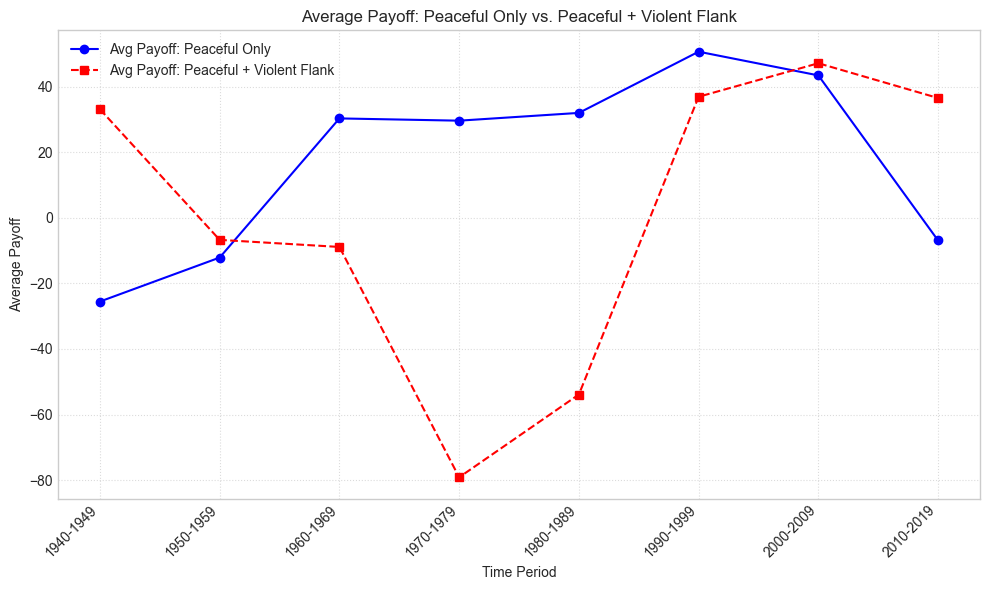

In [81]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

pdf_path = "exported_charts_pdf/payoff_peaceful_vs_flank.pdf"

if 'payoff_comparison_df' in locals() and not payoff_comparison_df.empty:
    # Save to PDF
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(10, 6))
        plt.plot(
            payoff_comparison_df.index,
            payoff_comparison_df['Avg Payoff: Peaceful Only'],
            marker='o',
            linestyle='-',
            color='blue',
            label='Avg Payoff: Peaceful Only'
        )
        plt.plot(
            payoff_comparison_df.index,
            payoff_comparison_df['Avg Payoff: Peaceful + Violent Flank'],
            marker='s',
            linestyle='--',
            color='red',
            label='Avg Payoff: Peaceful + Violent Flank'
        )
        plt.title('Average Payoff: Peaceful Only vs. Peaceful + Violent Flank')
        plt.xlabel('Time Period')
        plt.ylabel('Average Payoff')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    print(f"Saved: {pdf_path}")

    # Show interactively
    plt.figure(figsize=(10, 6))
    plt.plot(
        payoff_comparison_df.index,
        payoff_comparison_df['Avg Payoff: Peaceful Only'],
        marker='o',
        linestyle='-',
        color='blue',
        label='Avg Payoff: Peaceful Only'
    )
    plt.plot(
        payoff_comparison_df.index,
        payoff_comparison_df['Avg Payoff: Peaceful + Violent Flank'],
        marker='s',
        linestyle='--',
        color='red',
        label='Avg Payoff: Peaceful + Violent Flank'
    )
    plt.title('Average Payoff: Peaceful Only vs. Peaceful + Violent Flank')
    plt.xlabel('Time Period')
    plt.ylabel('Average Payoff')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("payoff_comparison_df is not defined or is empty.")

In [70]:
# DataFrame comparing number of purely peaceful vs. peaceful with violent flank campaigns per time period

if 'df_analyzed' in locals():
    grouped = df_analyzed.groupby('time_period', observed=True)
    num_peaceful_only = grouped.apply(
        lambda g: ((g['protester_strategy'] == 'p') & (g['VIOLENT FLANK'] == 0)).sum()
    )
    num_peaceful_flank = grouped.apply(
        lambda g: ((g['protester_strategy'] == 'p') & (g['VIOLENT FLANK'] == 1)).sum()
    )
    peaceful_type_counts_df = pd.DataFrame({
        'Num Peaceful Only': num_peaceful_only,
        'Num Peaceful + Violent Flank': num_peaceful_flank
    })
    print("Number of Purely Peaceful vs. Peaceful with Violent Flank Campaigns per Time Period:")
    display(peaceful_type_counts_df)
else:
    print("df_analyzed is not defined.")

Number of Purely Peaceful vs. Peaceful with Violent Flank Campaigns per Time Period:


/var/folders/dm/klqwbm8j69v1rbp8zzmpls4w0000gn/T/ipykernel_46348/2368040711.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_peaceful_only = grouped.apply(
/var/folders/dm/klqwbm8j69v1rbp8zzmpls4w0000gn/T/ipykernel_46348/2368040711.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_peaceful_flank = grouped.apply(


,Num Peaceful Only,Num Peaceful + Violent Flank
time_period,,
1940-1949,2,2
1950-1959,5,3
1960-1969,5,2
1970-1979,11,8
1980-1989,31,10
1990-1999,18,6
2000-2009,28,12
2010-2019,11,15


In [80]:
# Filter df_analyzed for only peaceful protests with a violent flank
peaceful_with_flank = df_analyzed[(df_analyzed['protester_strategy'] == 'p') & (df_analyzed['VIOLENT FLANK'] == 0)]

relevant_columns = [
    'NAVCO ID', 'CAMPAIGN', 'DURATION', 'NONVIOL', 'VIOLENT FLANK', 'protester_strategy', 'protester_payoff', 'regime_response_mapped', 'time_period'
]
peaceful_with_flank_relevant = peaceful_with_flank[relevant_columns].sort_values("time_period")



peaceful_with_flank_relevant

,NAVCO ID,CAMPAIGN,DURATION,NONVIOL,VIOLENT FLANK,protester_strategy,protester_payoff,regime_response_mapped,time_period
236,153,Independence Movement,2019,1,0,p,-50.95,l,1940-1949
157,378,KDPI (First Separatist Movement),502,1,0,p,-0.10,r,1940-1949
89,74,East German uprising,17,1,0,p,-25.85,r,1950-1959
356,19,anti-Jimenez campaign,12,1,0,p,94.40,f,1950-1959
208,157,Nyasaland African Congress,245,1,0,p,57.75,l,1950-1959
...,...,...,...,...,...,...,...,...,...
182,300,Anti-Interim Government,235,1,0,p,-36.75,r,2010-2019
283,335,Snow Revolution,1442,1,0,p,-72.10,r,2010-2019
175,320,Protest for Constitutional Reform,740,1,0,p,13.00,l,2010-2019
344,313,Anti-Erdogan,558,1,0,p,-27.90,r,2010-2019
